# Sampling

**Goal:** ...
  
This notebook is divided in two parts:
* **1. Bla**

In [34]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [25]:
sampling_strategy_summary = Summary()

## Get the data

In [69]:
%run ../impact_wrapper.py

In [61]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact')

features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']

data.process(features)

In [115]:
X, y = data.get_X_and_y('all', 'all')
data.print_info()

X: (194211, 45) | y: (194211,)


count_  freq_
False  187012  96.3%
True     7199   3.7%

In [70]:
X_1, y_1 = data.get_X_and_y('all', range(0 * data.positive_class_number, (0 + 1) * data.positive_class_number))
Impact_Wrapper.print_info(X_1, y_1)
X_2, y_2 = data.get_X_and_y('all', range(1 * data.positive_class_number, (1 + 1) * data.positive_class_number))
Impact_Wrapper.print_info(X_2, y_2)
X_3, y_3 = data.get_X_and_y('all', range(2 * data.positive_class_number, (2 + 1) * data.positive_class_number))
Impact_Wrapper.print_info(X_3, y_3)

X: (14398, 45) | y: (14398,)


count_  freq_
True     7199  50.0%
False    7199  50.0%

X: (14398, 45) | y: (14398,)


count_  freq_
True     7199  50.0%
False    7199  50.0%

X: (14398, 45) | y: (14398,)


count_  freq_
True     7199  50.0%
False    7199  50.0%

In [71]:
dataset_dict = {'sampling_1': {'X': X_1, 'y': y_1, 'metrics': pd.DataFrame()},
                'sampling_2': {'X': X_2, 'y': y_2, 'metrics': pd.DataFrame()},
                'sampling_3': {'X': X_3, 'y': y_3, 'metrics': pd.DataFrame()}}

## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [72]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Ridge Regression (L2 regularization)

In [119]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

for key, seed in zip(dataset_dict.keys(), [12, 1672, 456782]):
    
    print(seed)
    model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=seed),
                      StandardScaler(),
                      LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))
    
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'] = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall'])
    dataset_dict[key]['metrics'].print_mean()

12


**sampling_1**

Run model... done! (7.50s)
▴ Mean accuracy         : 0.891 ± 0.009
▴ Mean f1               : 0.309 ± 0.014
▴ Mean roc_auc          : 0.845 ± 0.006
▴ Mean average_precision: 0.497 ± 0.016
▴ Mean recall           : 0.657 ± 0.020
1672


**sampling_2**

Run model... done! (9.11s)
▴ Mean accuracy         : 0.891 ± 0.007
▴ Mean f1               : 0.311 ± 0.011
▴ Mean roc_auc          : 0.846 ± 0.003
▴ Mean average_precision: 0.497 ± 0.015
▴ Mean recall           : 0.661 ± 0.015
456782


**sampling_3**

Run model... done! (8.16s)
▴ Mean accuracy         : 0.896 ± 0.013
▴ Mean f1               : 0.319 ± 0.028
▴ Mean roc_auc          : 0.844 ± 0.006
▴ Mean average_precision: 0.499 ± 0.021
▴ Mean recall           : 0.655 ± 0.005


**sampling_1**

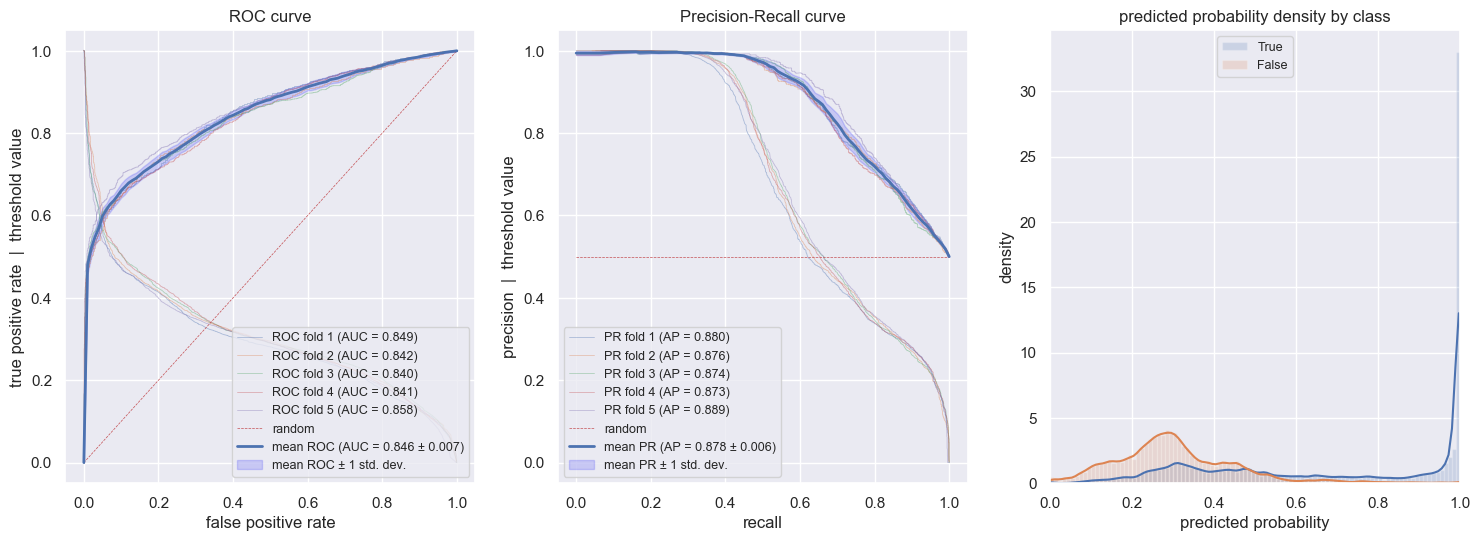

**sampling_2**

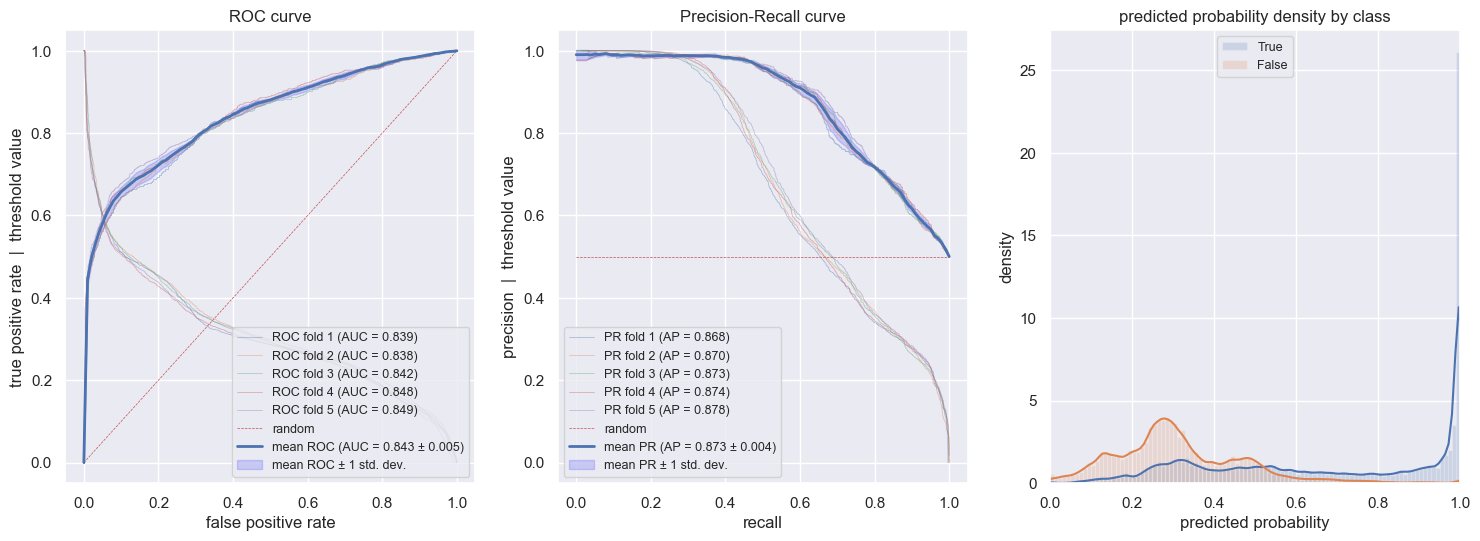

**sampling_3**

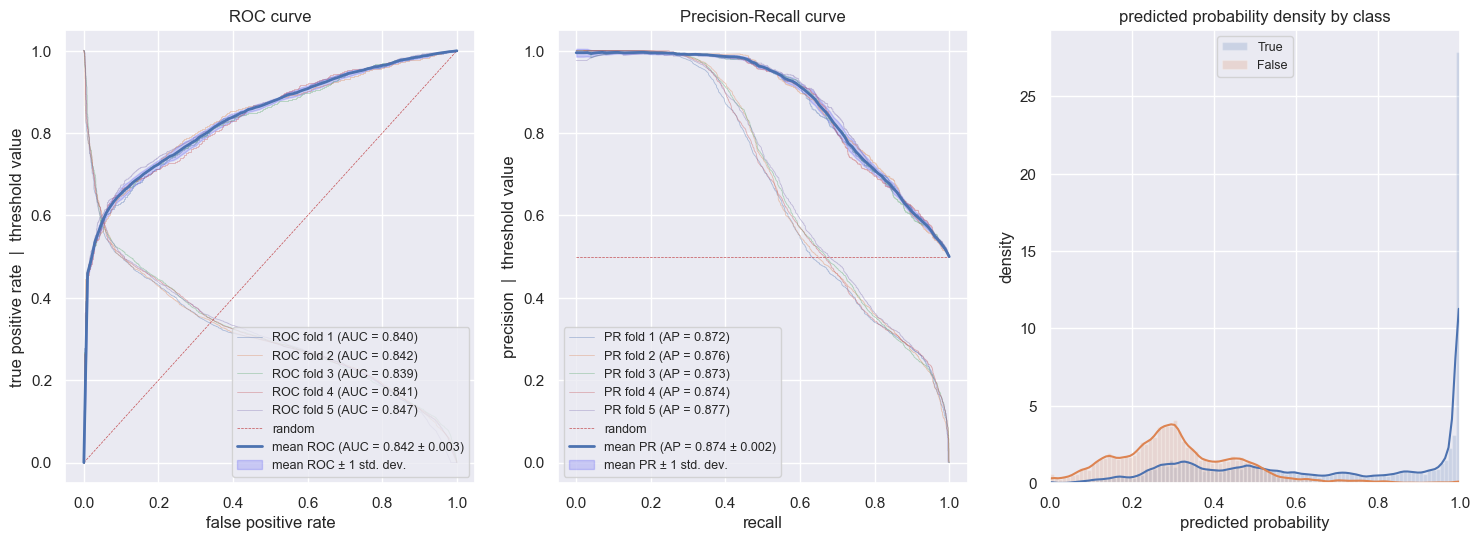

In [122]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'].plot_threshold_decision_curves(figsize=(18, 6))
    plt.show()

**sampling_1**

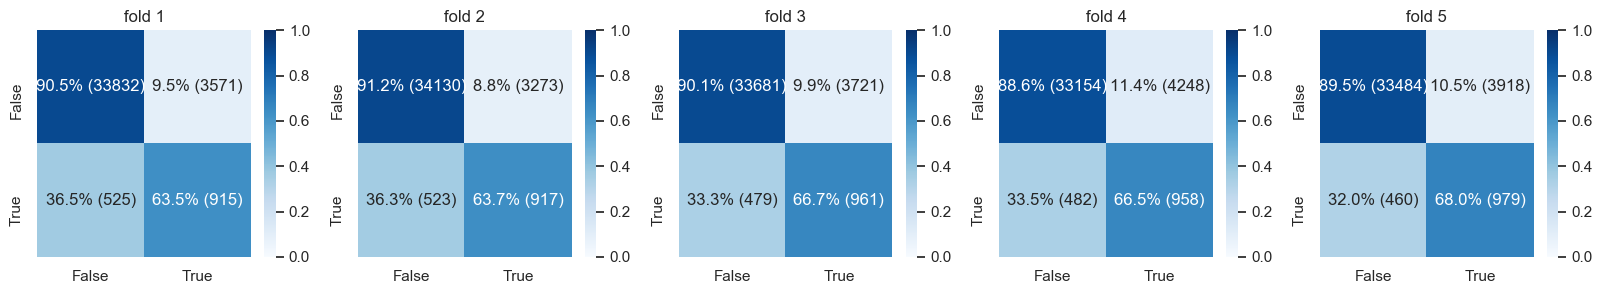

**sampling_2**

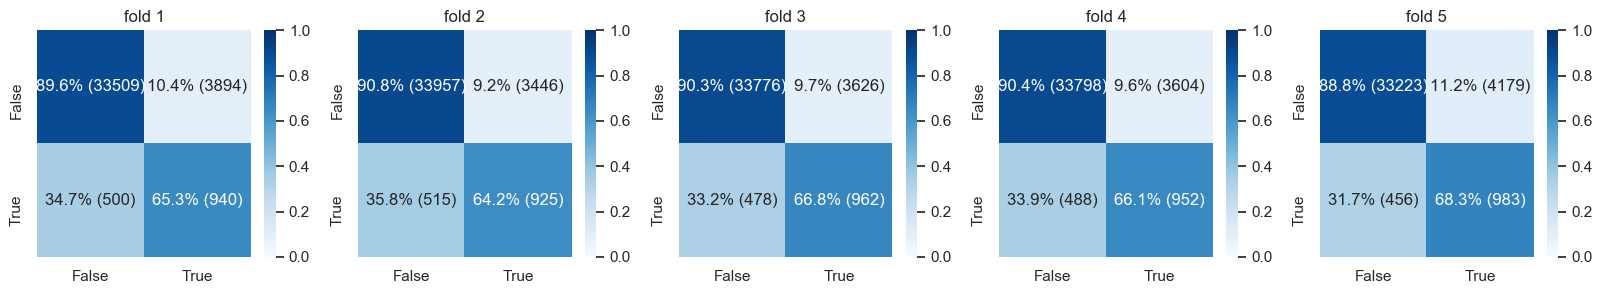

**sampling_3**

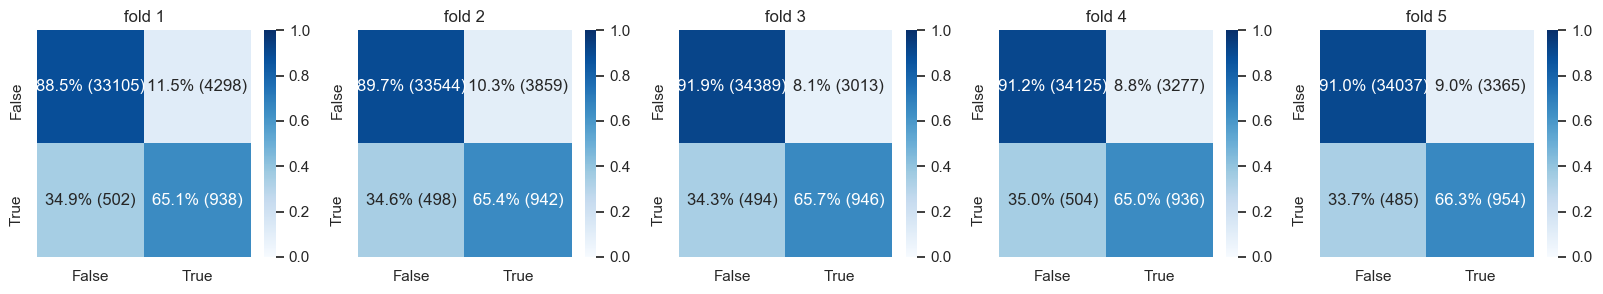

In [118]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'].plot_confusion_matrix()
    plt.show()

In [120]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'] = Metrics(model, dataset_dict[key]['X'], dataset_dict[key]['y'], cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall'])
    dataset_dict[key]['metrics'].print_mean()

**sampling_1**

Run model... done! (3.29s)
▴ Mean accuracy         : 0.779 ± 0.009
▴ Mean f1               : 0.746 ± 0.013
▴ Mean roc_auc          : 0.846 ± 0.007
▴ Mean average_precision: 0.878 ± 0.006
▴ Mean recall           : 0.647 ± 0.019


**sampling_2**

Run model... done! (3.32s)
▴ Mean accuracy         : 0.777 ± 0.008
▴ Mean f1               : 0.751 ± 0.010
▴ Mean roc_auc          : 0.843 ± 0.005
▴ Mean average_precision: 0.873 ± 0.004
▴ Mean recall           : 0.671 ± 0.014


**sampling_3**

Run model... done! (3.41s)
▴ Mean accuracy         : 0.776 ± 0.007
▴ Mean f1               : 0.746 ± 0.012
▴ Mean roc_auc          : 0.842 ± 0.003
▴ Mean average_precision: 0.874 ± 0.002
▴ Mean recall           : 0.659 ± 0.019


**sampling_1**

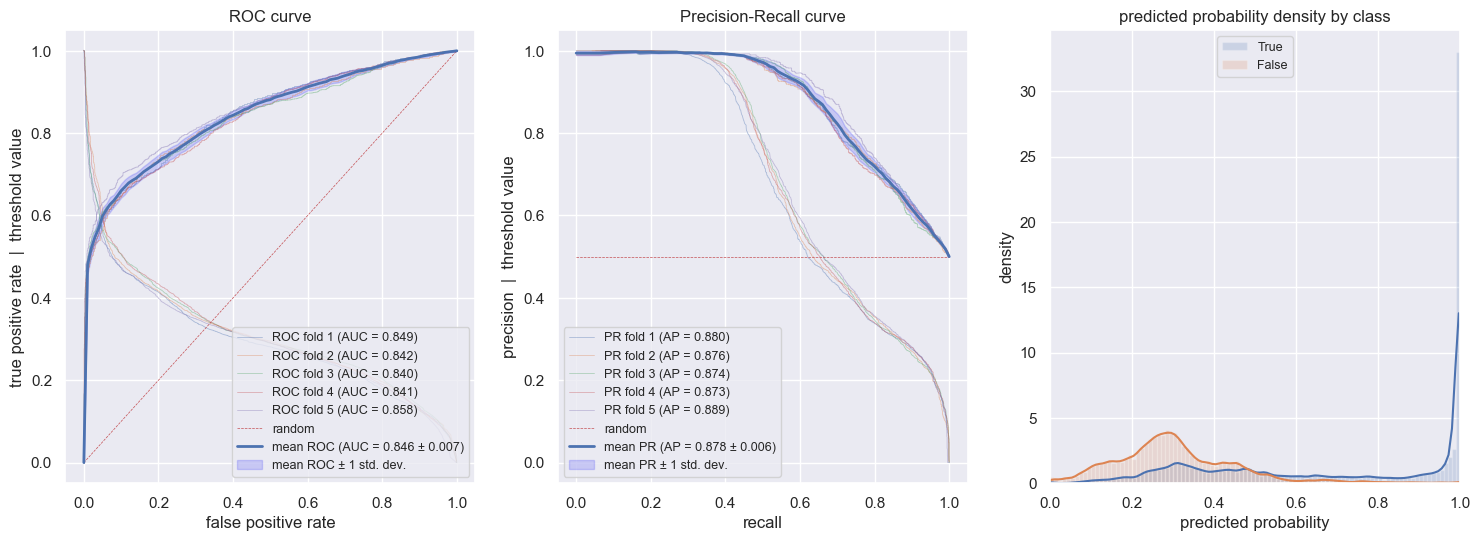

**sampling_2**

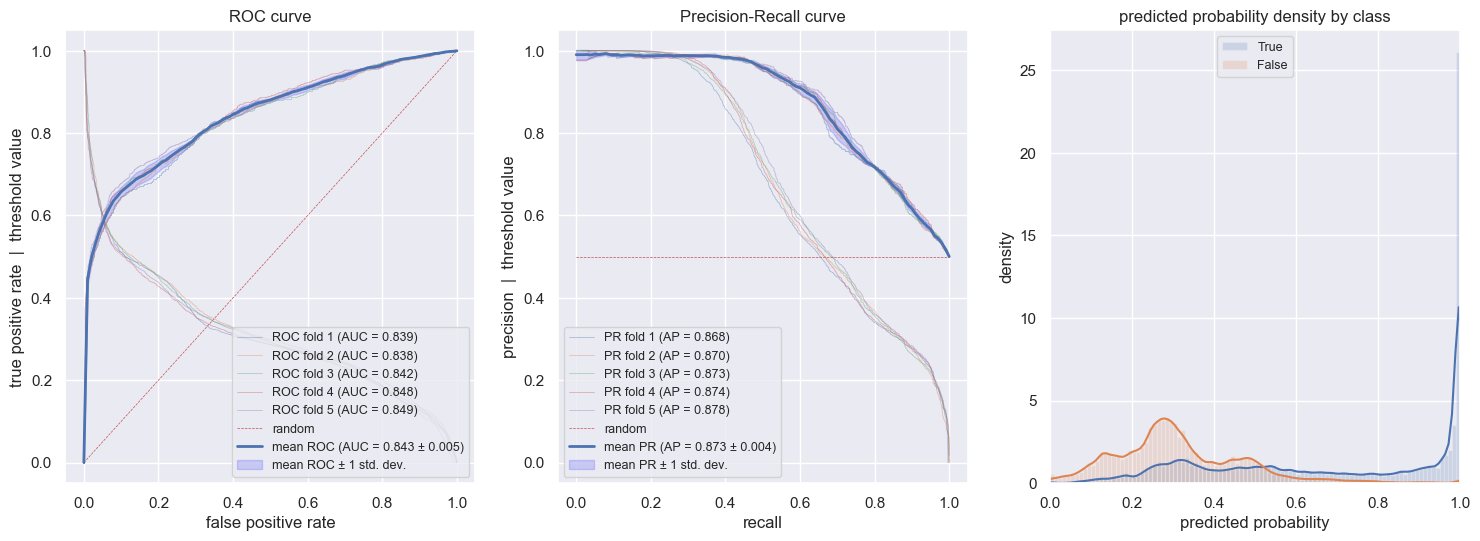

**sampling_3**

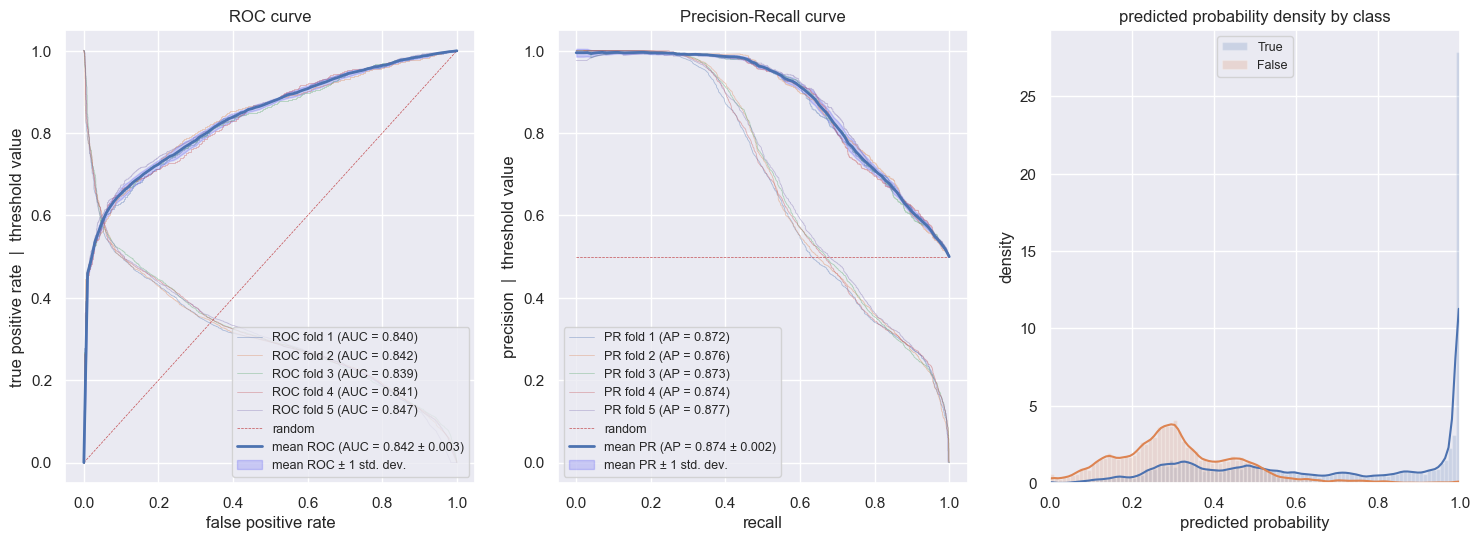

In [76]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'].plot_threshold_decision_curves(figsize=(18, 6))
    plt.show()

**sampling_1**

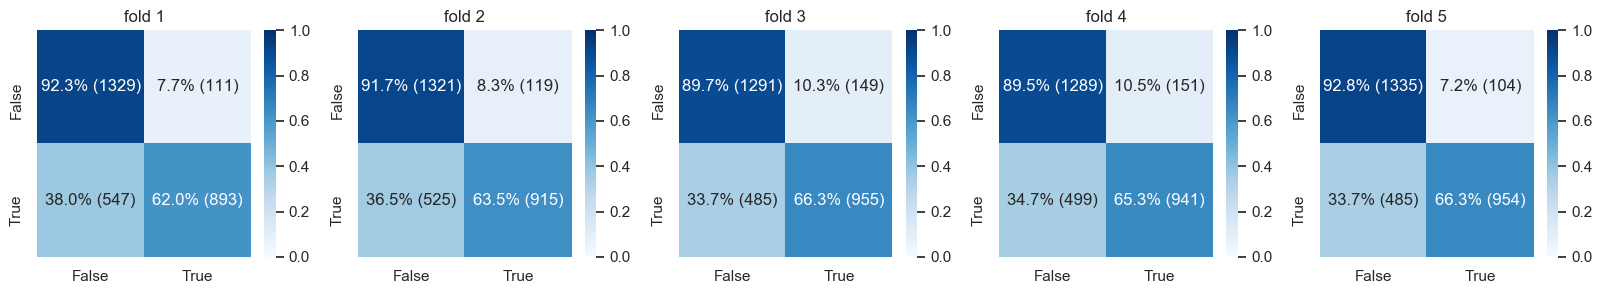

**sampling_2**

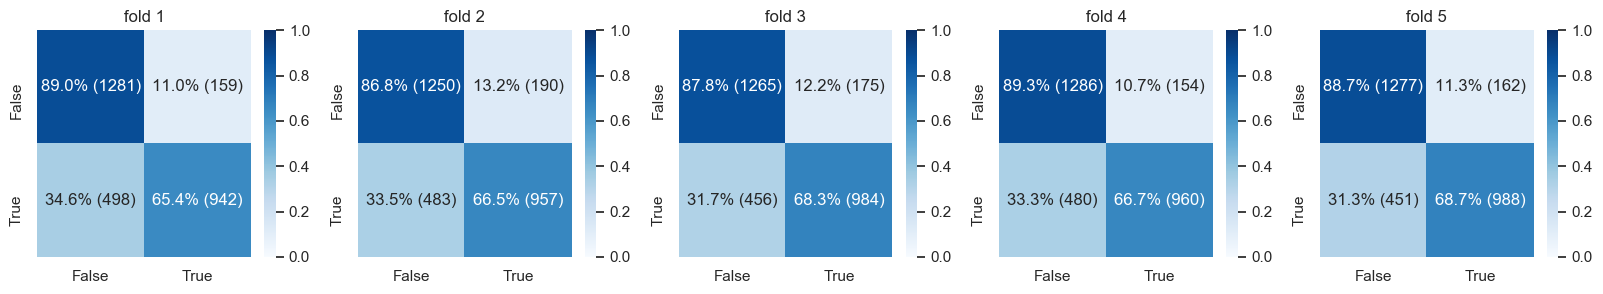

**sampling_3**

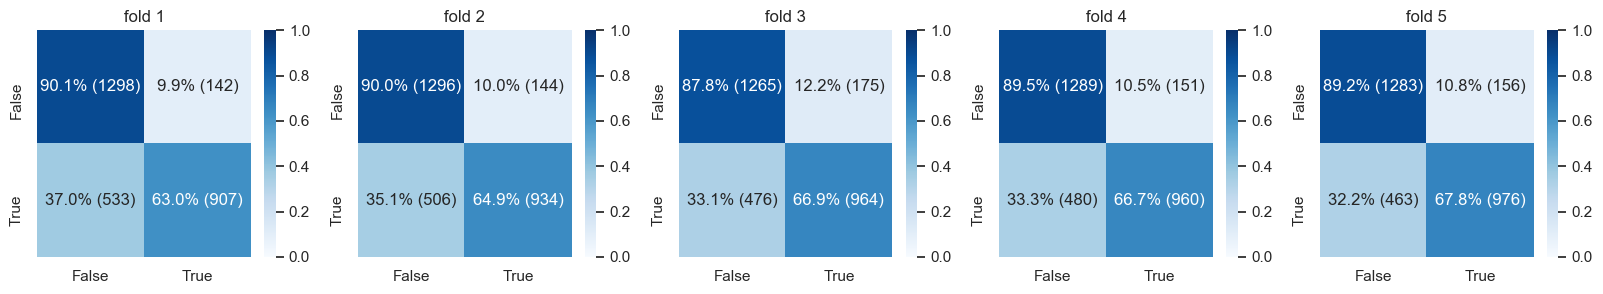

In [77]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'].plot_confusion_matrix()
    plt.show()

In [100]:
for (key, color) in zip(dataset_dict.keys(), ['crimson', 'tomato', 'coral']):
    sampling_strategy_summary.add(dataset_dict[key]['metrics'], 'RidgeRegression_%s' % key, color)

## Random Forest

### Create job

In [ ]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs'))

In [88]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ job found and reloaded

In [83]:
for job in job_list:
    job.load_data(dataset_dict[job.job_id[13:]]['X'], dataset_dict[job.job_id[13:]]['y'])

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_1


<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_2


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_3


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ data loaded

In [84]:
%%writefile {job_list[0].script_path}

# load the ml_tools functions
%run ../../metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ../ssh_remote_jobs/job_RandomForest_sampling_1/script.ipy


In [85]:
!cp {job_list[0].script_path} {job_list[1].script_path}
!cp {job_list[0].script_path} {job_list[2].script_path}

In [86]:
for job in job_list:
    job.run(n_jobs=10, short_job=True, memory=16)

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_1 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1533    29.2KB/s   00:00    
metrics.pkl                                   100%  472KB   5.2MB/s   00:00    
script.ipy                                    100%  903    26.8KB/s   00:00    
X.pkl                                         100% 3268KB   5.4MB/s   00:00    
y.pkl                                         100%   15KB 317.6KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_1
Job <28767561> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_1 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_2 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1533    93.9KB/s   00:00    
metrics.pkl                                   100%  492KB   7.1MB/s   00:00    
script.ipy                                    100%  903    18.7KB/s   00:00    
X.pkl                                         100% 3268KB   9.9MB/s   00:00    
y.pkl                                         100%   15KB 446.7KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_2
Job <28767563> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_2 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_3 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1531   130.3KB/s   00:00    
metrics.pkl                                   100%  447KB   5.6MB/s   00:00    
script.ipy                                    100%  903    14.2KB/s   00:00    
X.pkl                                         100% 3268KB   9.9MB/s   00:00    
y.pkl                                         100%   15KB 200.3KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_3
Job <28767566> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_3 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ submitted<br>

In [89]:
for job in job_list:
    job.get_results()

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_1 to ../ssh_remote_jobs/job_RandomForest_sampling_1
metrics.pkl                                   100%  540KB   4.0MB/s   00:00    
job_output.txt                                100% 1534   108.4KB/s   00:00    
➞ load metrics.pkl in object self.metrics
➞ print main results
▴ Mean accuracy         : 0.819 ± 0.009
▴ Mean f1               : 0.802 ± 0.011
▴ Mean roc_auc          : 0.895 ± 0.006
▴ Mean average_precision: 0.916 ± 0.006


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_2 to ../ssh_remote_jobs/job_RandomForest_sampling_2
metrics.pkl                                   100%  553KB   5.1MB/s   00:00    
job_output.txt                                100% 1534   304.9KB/s   00:00    
➞ load metrics.pkl in object self.metrics
➞ print main results
▴ Mean accuracy         : 0.814 ± 0.008
▴ Mean f1               : 0.798 ± 0.010
▴ Mean roc_auc          : 0.892 ± 0.004
▴ Mean average_precision: 0.911 ± 0.004


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_3 to ../ssh_remote_jobs/job_RandomForest_sampling_3
metrics.pkl                                   100%  549KB   6.1MB/s   00:00    
job_output.txt                                100% 1534   403.9KB/s   00:00    
➞ load metrics.pkl in object self.metrics
➞ print main results
▴ Mean accuracy         : 0.814 ± 0.007
▴ Mean f1               : 0.797 ± 0.010
▴ Mean roc_auc          : 0.892 ± 0.004
▴ Mean average_precision: 0.912 ± 0.004


**RandomForest_sampling_1**

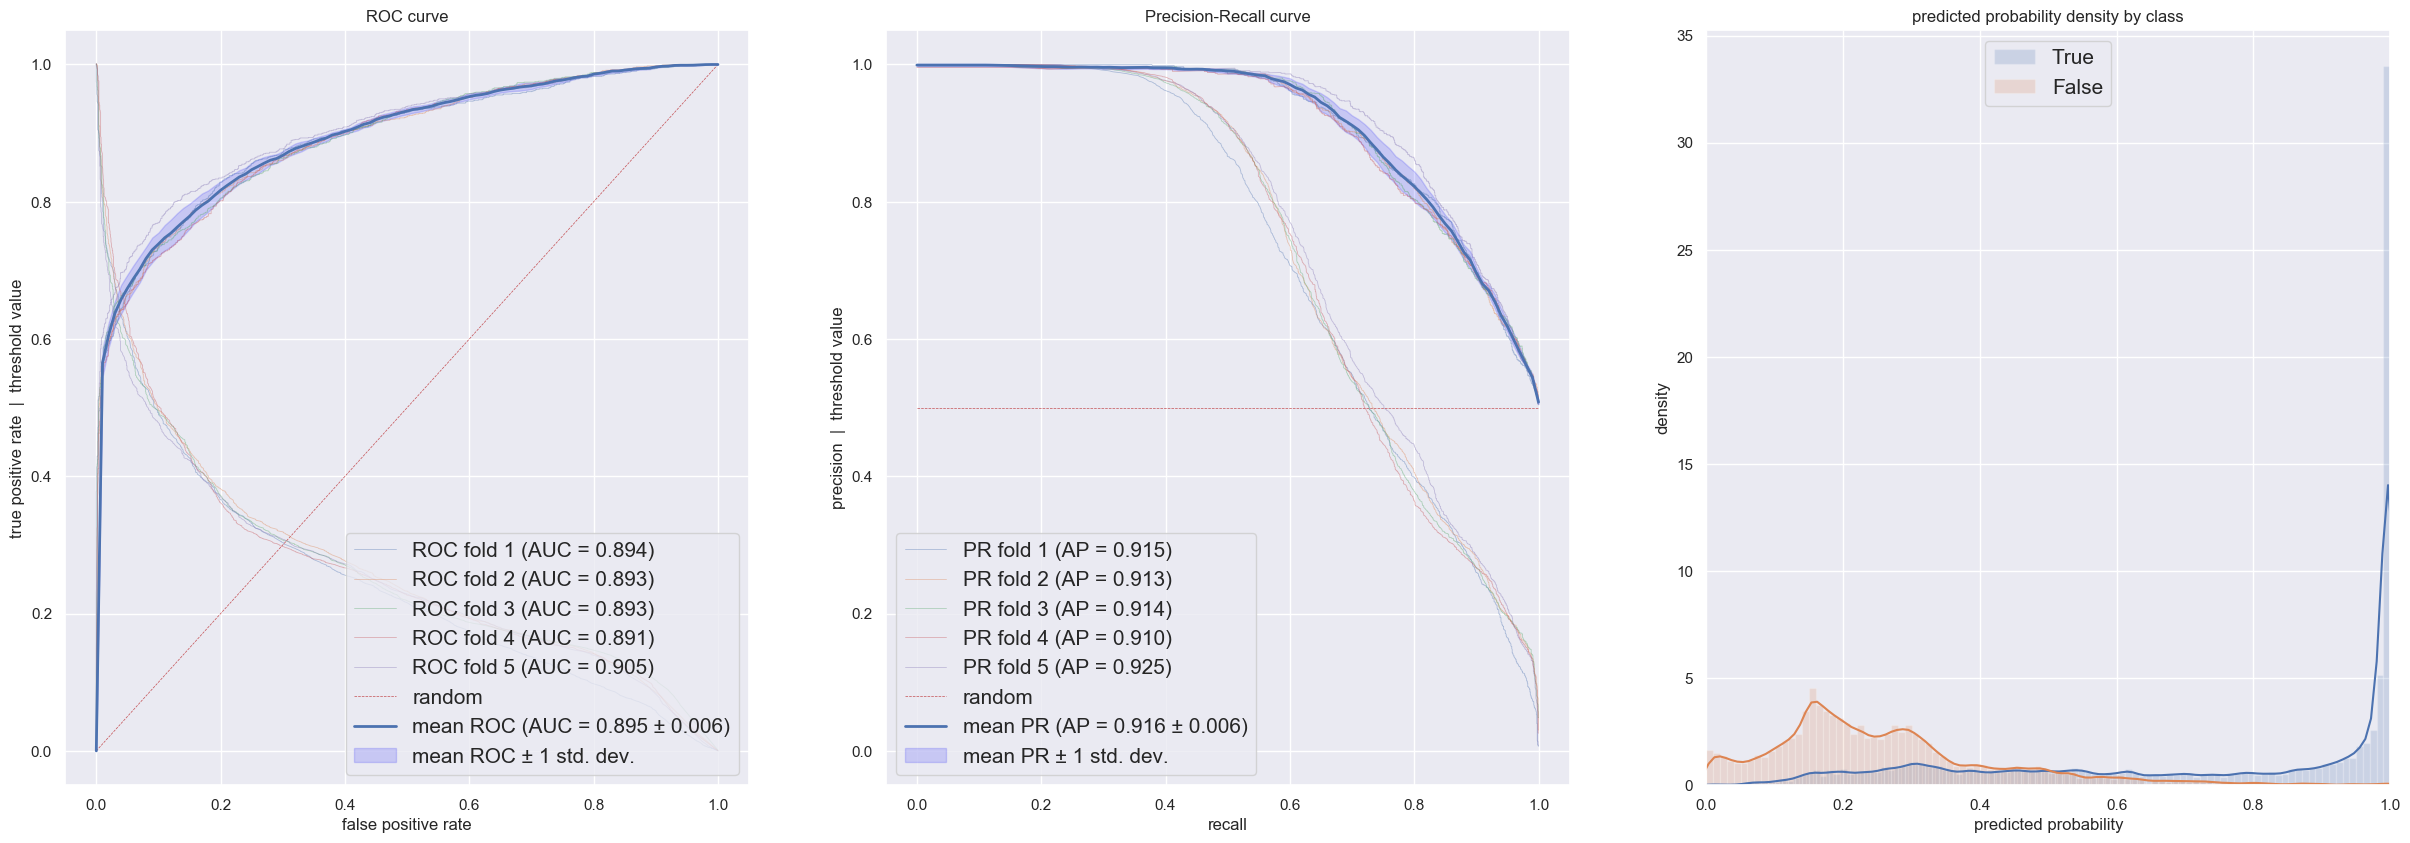

**RandomForest_sampling_2**

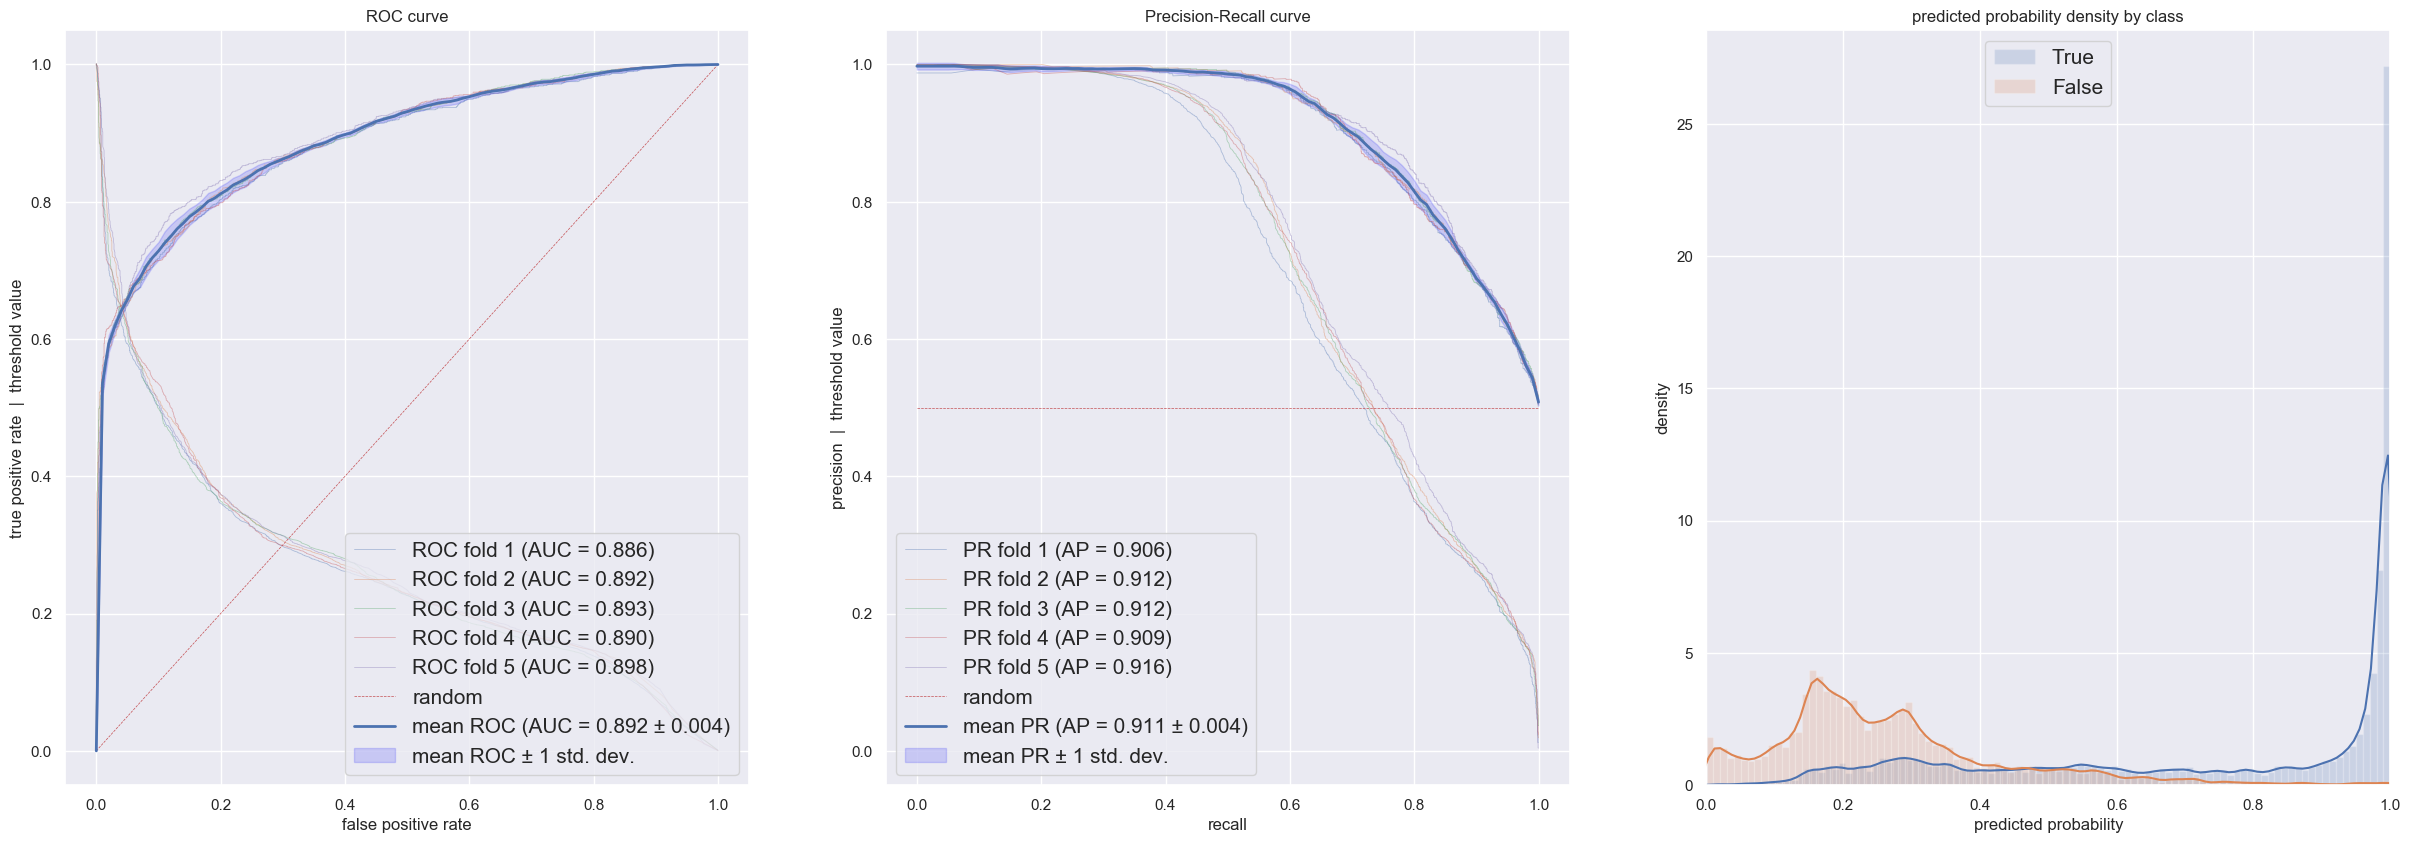

**RandomForest_sampling_3**

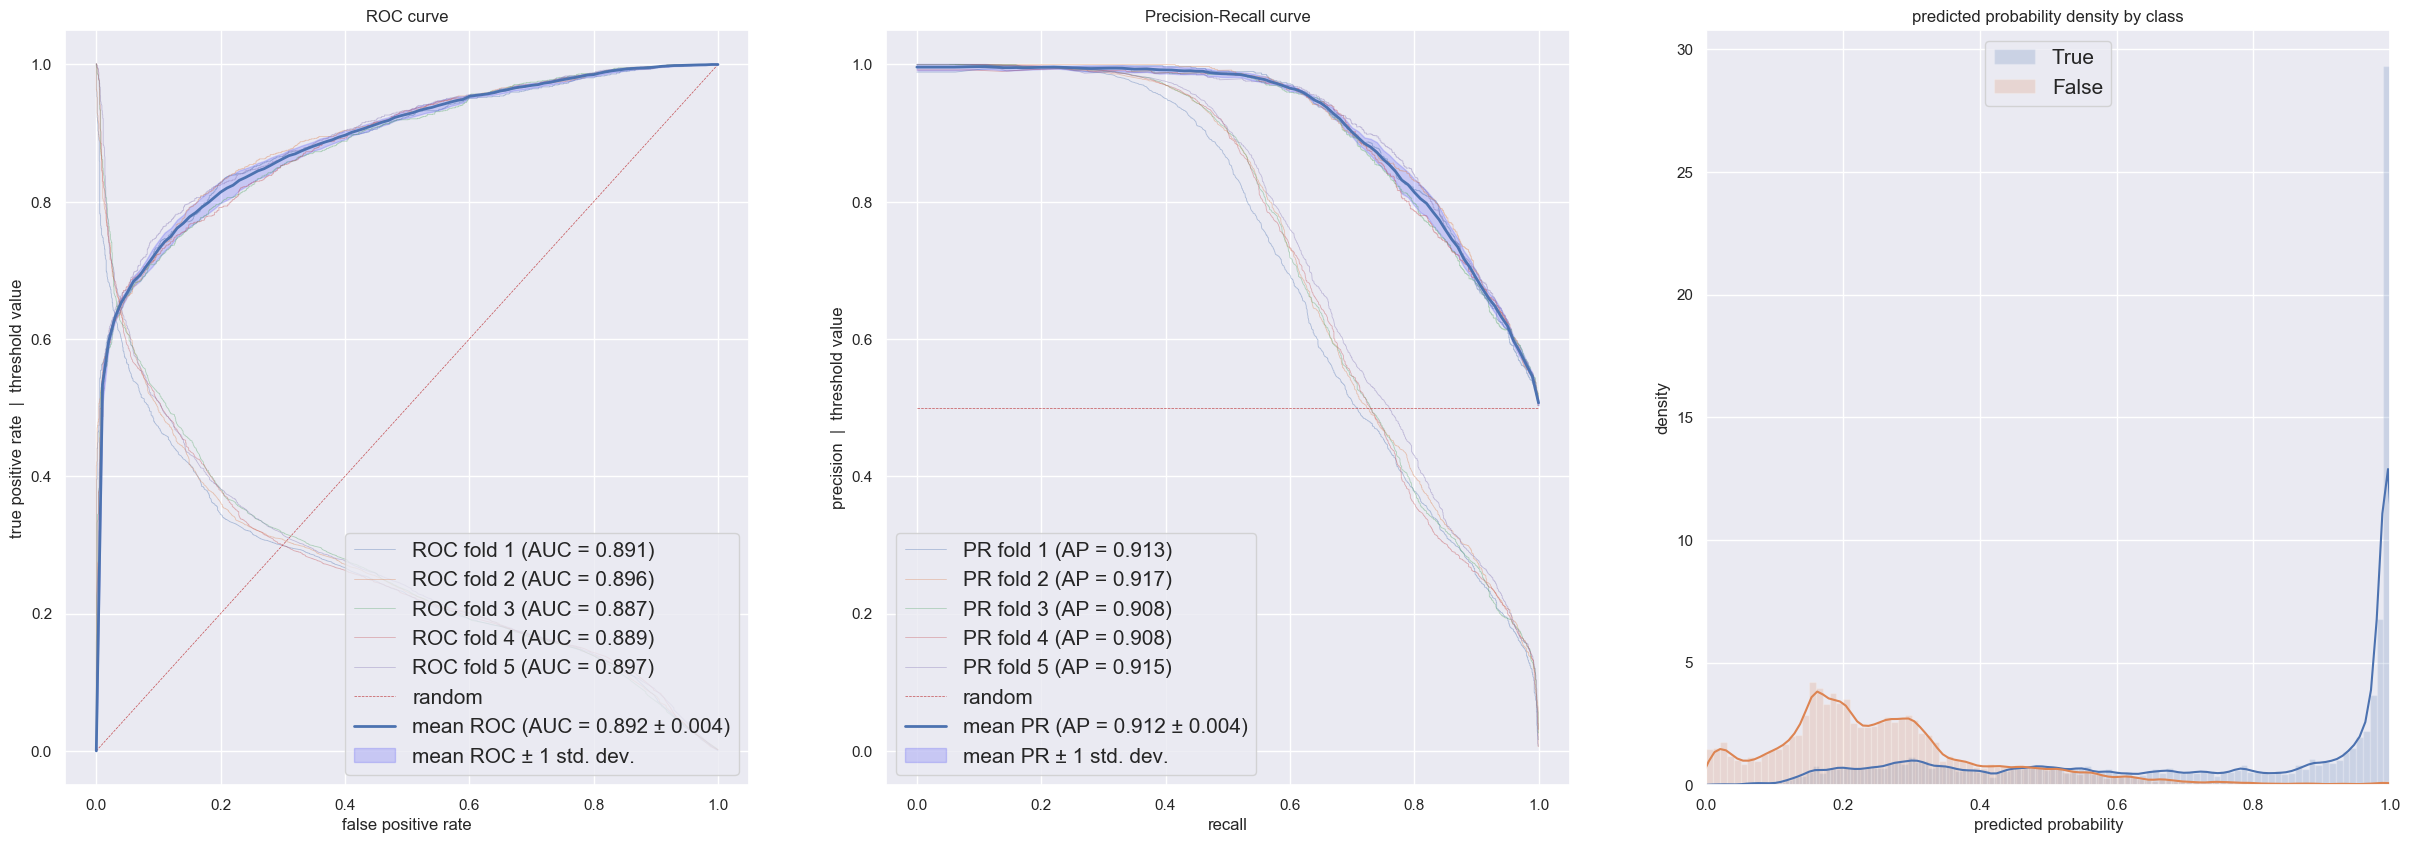

In [90]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        job.metrics.plot_threshold_decision_curves()
        plt.show()

**RandomForest_sampling_1**

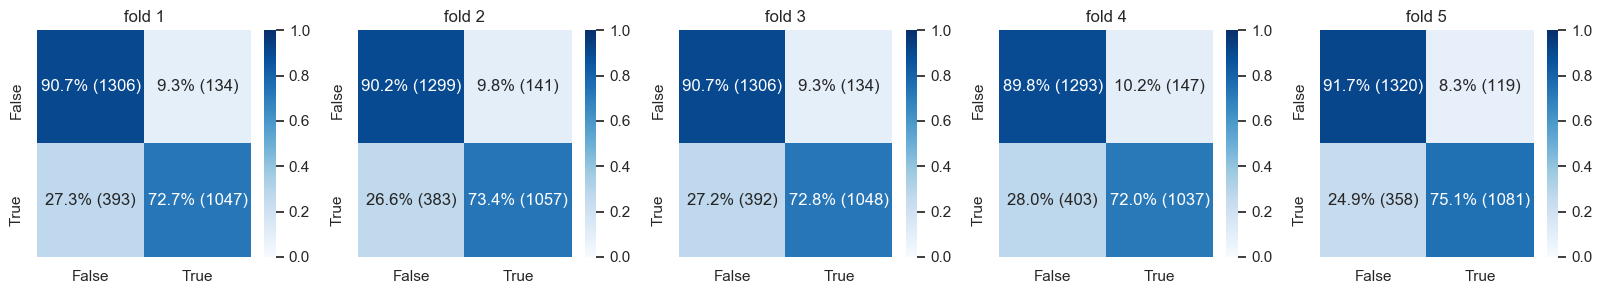

**RandomForest_sampling_2**

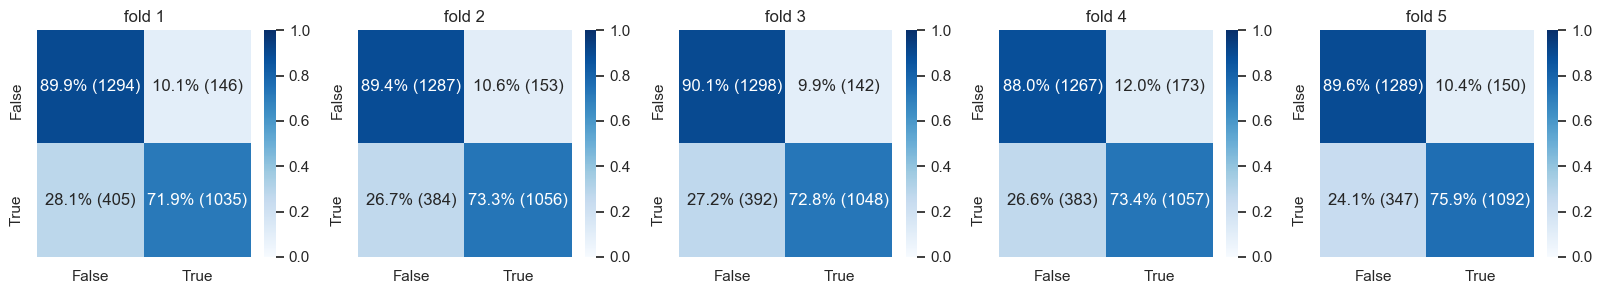

**RandomForest_sampling_3**

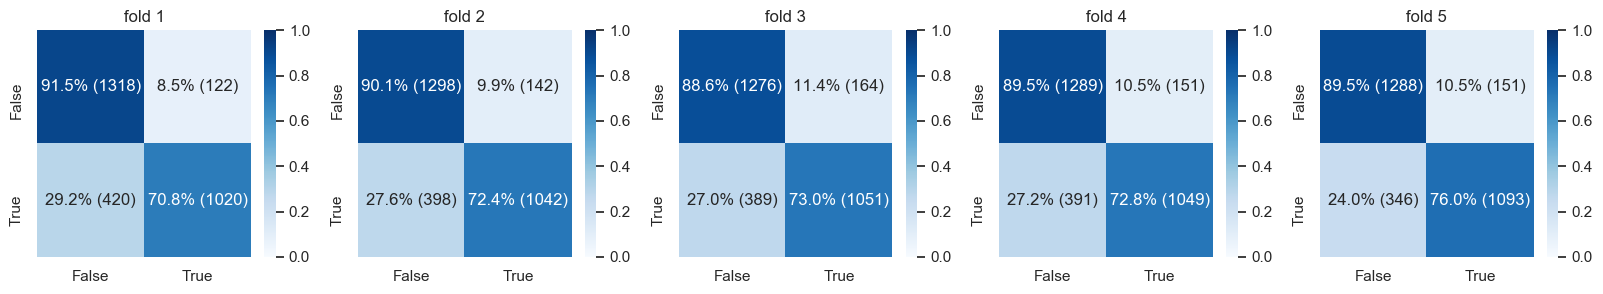

In [91]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        job.metrics.plot_confusion_matrix()
        plt.show()

In [95]:
%run ../metrics.py

<Figure size 600x600 with 0 Axes>

**sampling_1**

Fit model... done! (5.58s)


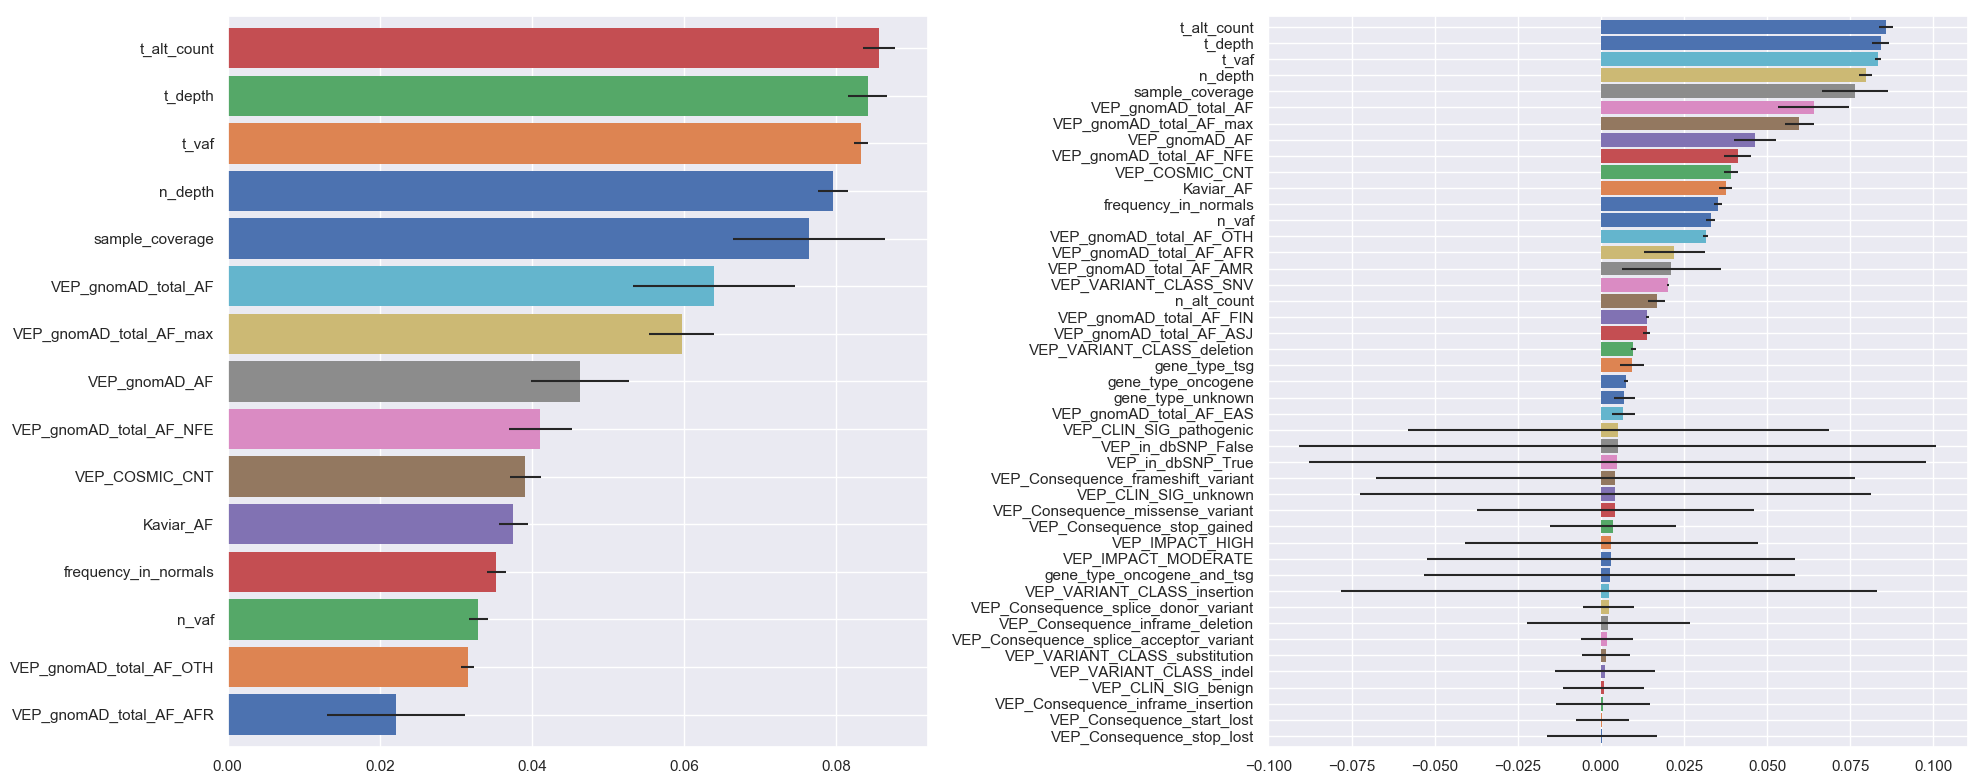

**sampling_2**

Fit model... done! (6.62s)


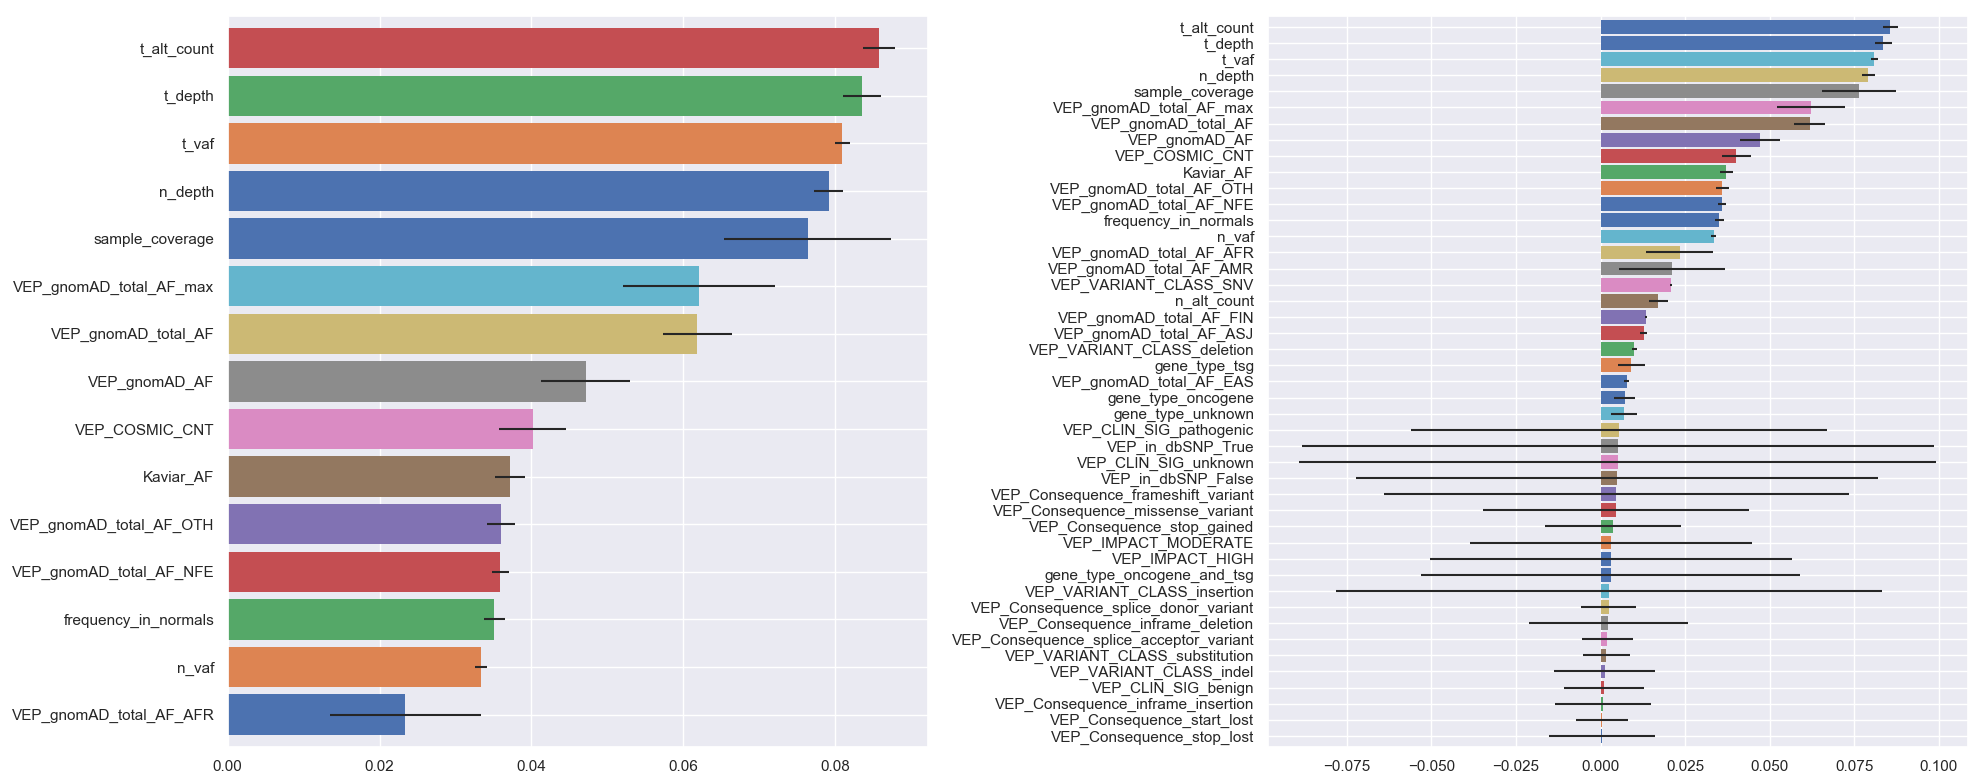

**sampling_3**

Fit model... done! (7.18s)


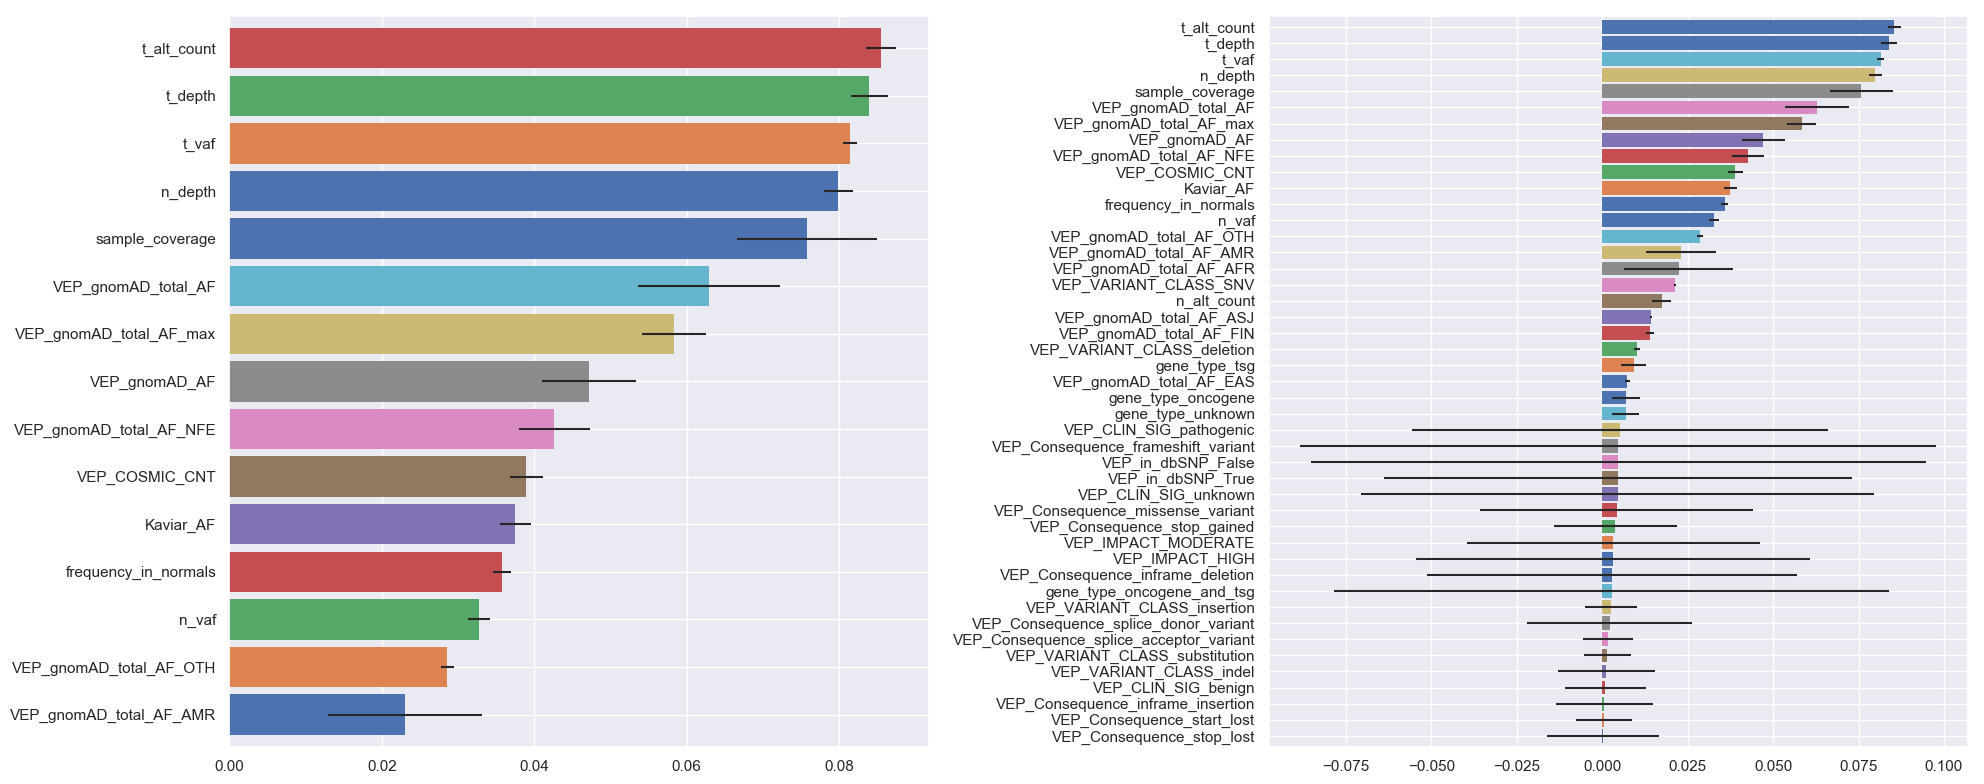

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

model_bestRF = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5)

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    metrics = Metrics(model_bestRF, dataset_dict[key]['X'], dataset_dict[key]['y'], cv_strategy, n_jobs=5, run_model=False)
    metrics.plot_features_importance(random_forest=True)
    plt.show()

In [101]:
for (job, color) in zip(job_list, ['darkblue', 'indigo', 'purple']):
    if hasattr(job, 'metrics'):
        sampling_strategy_summary.add(job.metrics, job.job_id, color)

## Get the data - unified IMPACT

In [135]:
%run ../impact_wrapper.py

<Figure size 600x600 with 0 Axes>

In [136]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact')

In [137]:
def get_random_sample(x, max_number):
    if x.shape[0] > max_number:
        return x.sample(max_number, random_state=42).tolist()
    else:
        return x.tolist()

aggregation = {
    'mut_key': {'number': 'count'},
    
    'sample_mut_key': {'list': lambda x: x.tolist(),
                       'selected': lambda x: get_random_sample(x, 3)}
}

dd = data.impact.groupby('mut_key').aggregate(aggregation)
dd.head(10)

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key  \
                                  number   
mut_key                                    
10_104263912_G_A                       1   
10_104263932_GCGCCCCCGGCCCCACC_-       2   
10_104263935_C_-                       1   
10_104263935_C_T                       1   
10_104263941_G_A                       3   
10_104263952_C_-                       1   
10_104263959_C_T                       1   
10_104263973_-_C                      12   
10_104263974_C_-                       3   
10_104263979_C_A                       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sample_mut_key  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              list   
mut_key                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
10_104263912_G_A                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0004423-T01-IM5_10_104263912_G_A]   
10_104263932_GCGCCCCCGGCCCCACC_-                                                                                                                                                                                                                                                                                                                                          [P-0001027-T01-IM3_10_104263932_GCGCCCCCGGCCCCACC_-, P-0015687-T01-IM6_10_104263932_GCGCCCCCGGCCCCACC_-]   
10_104263935_C_-                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0015938-T01-IM6_10_104263935_C_-]   
10_104263935_C_T                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0012445-T01-IM5_10_104263935_C_T]   
10_104263941_G_A                                                                                                                                                          

In [138]:
selected_sample_mut_key = [x for sublist in dd.sample_mut_key.selected for x in sublist]

print(data.impact.shape)
data.impact = data.impact[data.impact.sample_mut_key.isin(selected_sample_mut_key)].copy()
print(data.impact.shape)

(194211, 63)
(160752, 63)


In [139]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']

data.process(features)

In [141]:
X, y = data.get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (160752, 45) | y: (160752,)


count_  freq_
False  155564  96.8%
True     5188   3.2%

In [143]:
X_1, y_1 = data.get_X_and_y('all', range(0 * data.positive_class_number, (0 + 1) * data.positive_class_number))
Impact_Wrapper.print_info(X_1, y_1)
X_2, y_2 = data.get_X_and_y('all', range(1 * data.positive_class_number, (1 + 1) * data.positive_class_number))
Impact_Wrapper.print_info(X_2, y_2)
X_3, y_3 = data.get_X_and_y('all', range(2 * data.positive_class_number, (2 + 1) * data.positive_class_number))
Impact_Wrapper.print_info(X_3, y_3)

X: (10376, 45) | y: (10376,)


count_  freq_
True     5188  50.0%
False    5188  50.0%

X: (10376, 45) | y: (10376,)


count_  freq_
True     5188  50.0%
False    5188  50.0%

X: (10376, 45) | y: (10376,)


count_  freq_
True     5188  50.0%
False    5188  50.0%

In [144]:
dataset_dict = {'sampling_1': {'X': X_1, 'y': y_1, 'metrics': pd.DataFrame()},
                'sampling_2': {'X': X_2, 'y': y_2, 'metrics': pd.DataFrame()},
                'sampling_3': {'X': X_3, 'y': y_3, 'metrics': pd.DataFrame()}}

## Ridge Regression (L2 regularization) - unified IMPACT

In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'] = run_model(model, dataset_dict[key]['X'], dataset_dict[key]['y'], cv_strategy, n_jobs=5)
    print_mean_metrics(dataset_dict[key]['metrics'])

**sampling_1**

Run model... done! (2.90s)
▴ Mean accuracy    : 0.789 ± 0.023
▴ Mean ROC AUC     : 0.861 ± 0.009
▴ Mean F1-score    : 0.768 ± 0.028
▴ Average precision: 0.885 ± 0.010


**sampling_2**

Run model... done! (3.04s)
▴ Mean accuracy    : 0.779 ± 0.024
▴ Mean ROC AUC     : 0.846 ± 0.014
▴ Mean F1-score    : 0.753 ± 0.029
▴ Average precision: 0.877 ± 0.014


**sampling_3**

Run model... done! (2.90s)
▴ Mean accuracy    : 0.816 ± 0.011
▴ Mean ROC AUC     : 0.884 ± 0.010
▴ Mean F1-score    : 0.803 ± 0.011
▴ Average precision: 0.907 ± 0.008


**sampling_1**

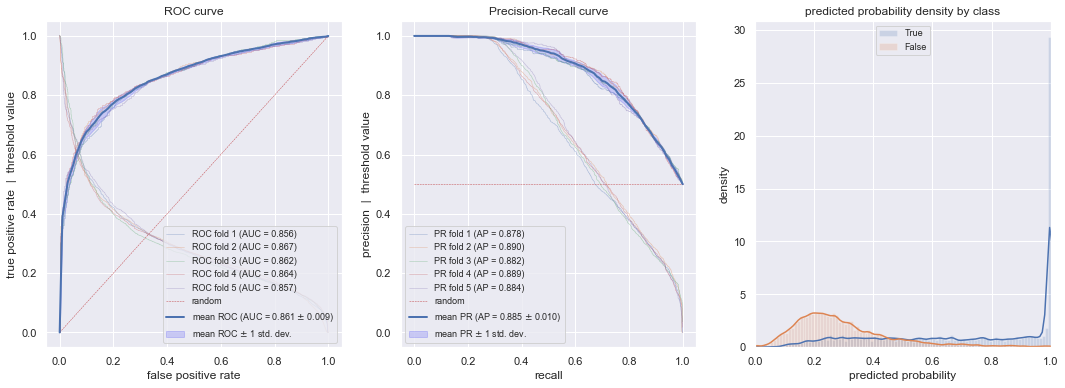

**sampling_2**

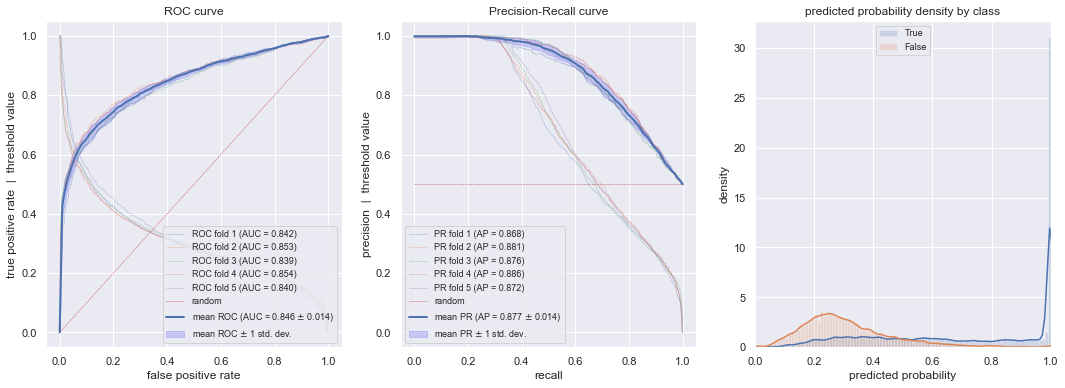

**sampling_3**

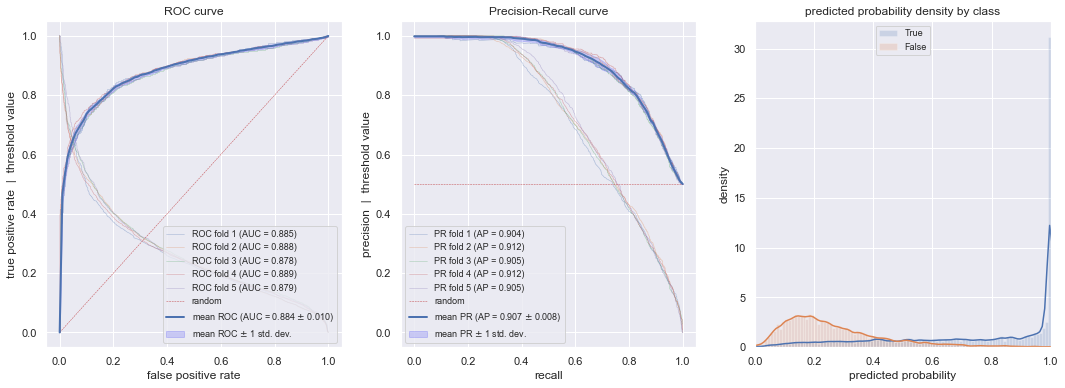

In [25]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_threshold_decision_metrics(dataset_dict[key]['metrics'], figsize=(18, 6))
    plt.show()

**sampling_1**

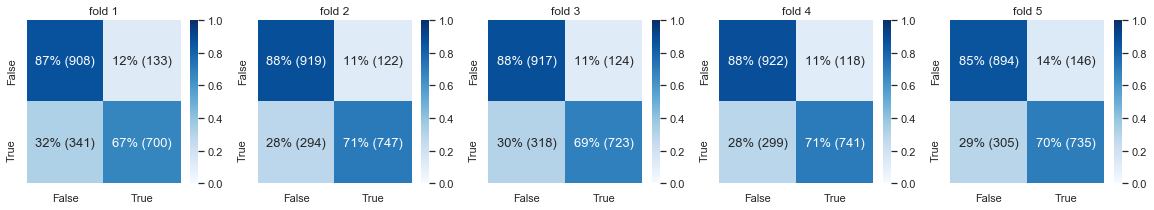

**sampling_2**

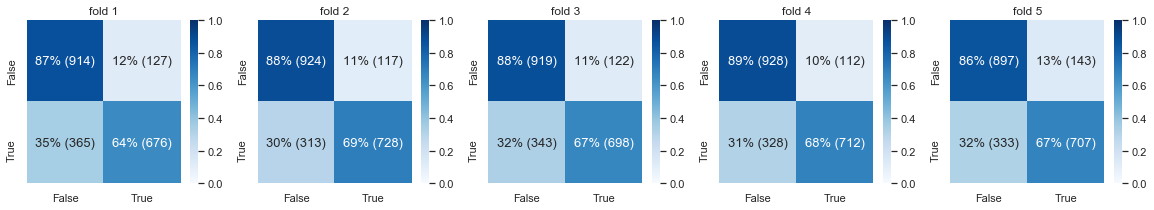

**sampling_3**

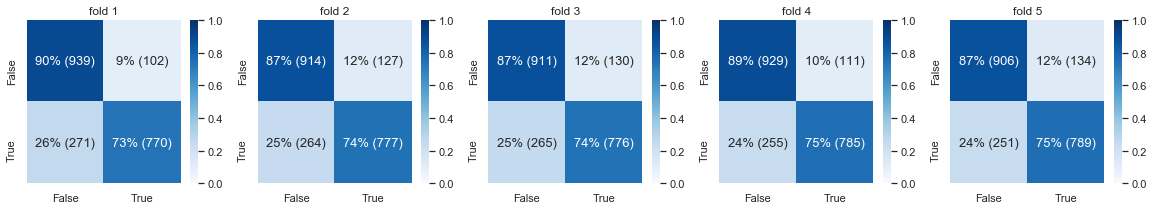

In [26]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_confusion_matrix(dataset_dict[key]['metrics'])
    plt.show()

In [27]:
for key in dataset_dict.keys():
    add_metrics_to_summary(summary, dataset_dict[key]['metrics'], 'RidgeRegression_unified_%s' % key)

## Random Forest  - unified IMPACT

### Create job

In [48]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_unified_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs'))

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_1


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_2


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_3


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ created

In [29]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_unified_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ job found and reloaded

In [61]:
for job in job_list:
    job.load_data(dataset_dict[job.job_id[21:]]['X'], dataset_dict[job.job_id[21:]]['y'])

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_1


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_2


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_3


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ data loaded

In [62]:
%%writefile {job_list[0].script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=10)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ../ssh_remote_jobs/job_RandomForest_unified_sampling_1/script.ipy


In [63]:
!cp {job_list[0].script_path} {job_list[1].script_path}
!cp {job_list[0].script_path} {job_list[2].script_path}

In [64]:
for job in job_list:
    job.run(n_jobs=10, short_job=True, memory=16)

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_1 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     1.4KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  27.9KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_1
Job <28727221> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_1 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_2 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     1.7KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  28.0KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_2
Job <28727266> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_2 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_3 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     2.4KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  22.5KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_3
Job <28727316> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_3 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ submitted<br>

In [30]:
for job in job_list:
    job.get_results()

<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_1 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_1
metrics.pkl                                   100%  379KB   6.6MB/s   00:00    
job_output.txt                                100% 1554   566.7KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.838 ± 0.005
▴ Mean ROC AUC     : 0.916 ± 0.004
▴ Mean F1-score    : 0.833 ± 0.008
▴ Average precision: 0.929 ± 0.004


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_2 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_2
metrics.pkl                                   100%  389KB   6.1MB/s   00:00    
job_output.txt                                100% 1555   317.6KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.831 ± 0.022
▴ Mean ROC AUC     : 0.904 ± 0.010
▴ Mean F1-score    : 0.823 ± 0.024
▴ Average precision: 0.918 ± 0.011


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_3 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_3
metrics.pkl                                   100%  390KB   6.8MB/s   00:00    
job_output.txt                                100% 1554   622.2KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.856 ± 0.009
▴ Mean ROC AUC     : 0.926 ± 0.008
▴ Mean F1-score    : 0.852 ± 0.010
▴ Average precision: 0.936 ± 0.005


**RandomForest_unified_sampling_1**

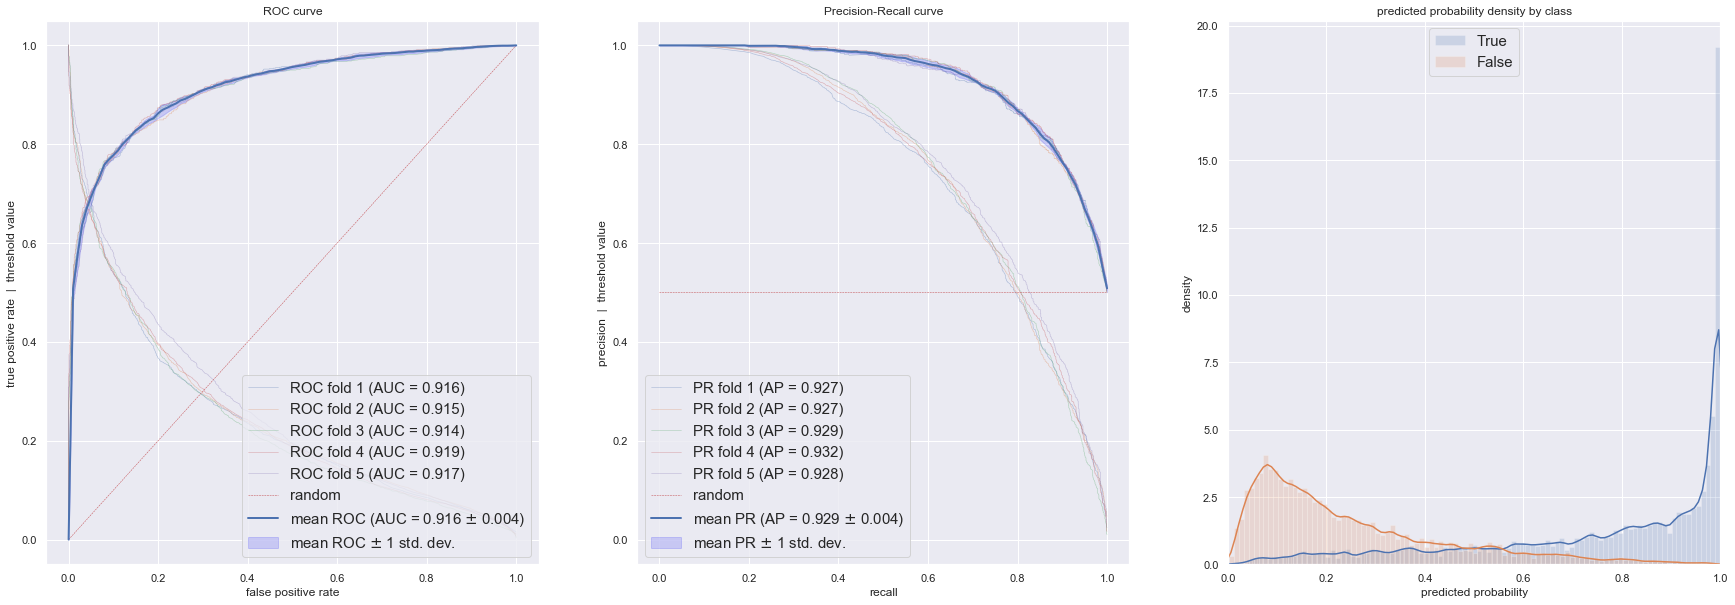

**RandomForest_unified_sampling_2**

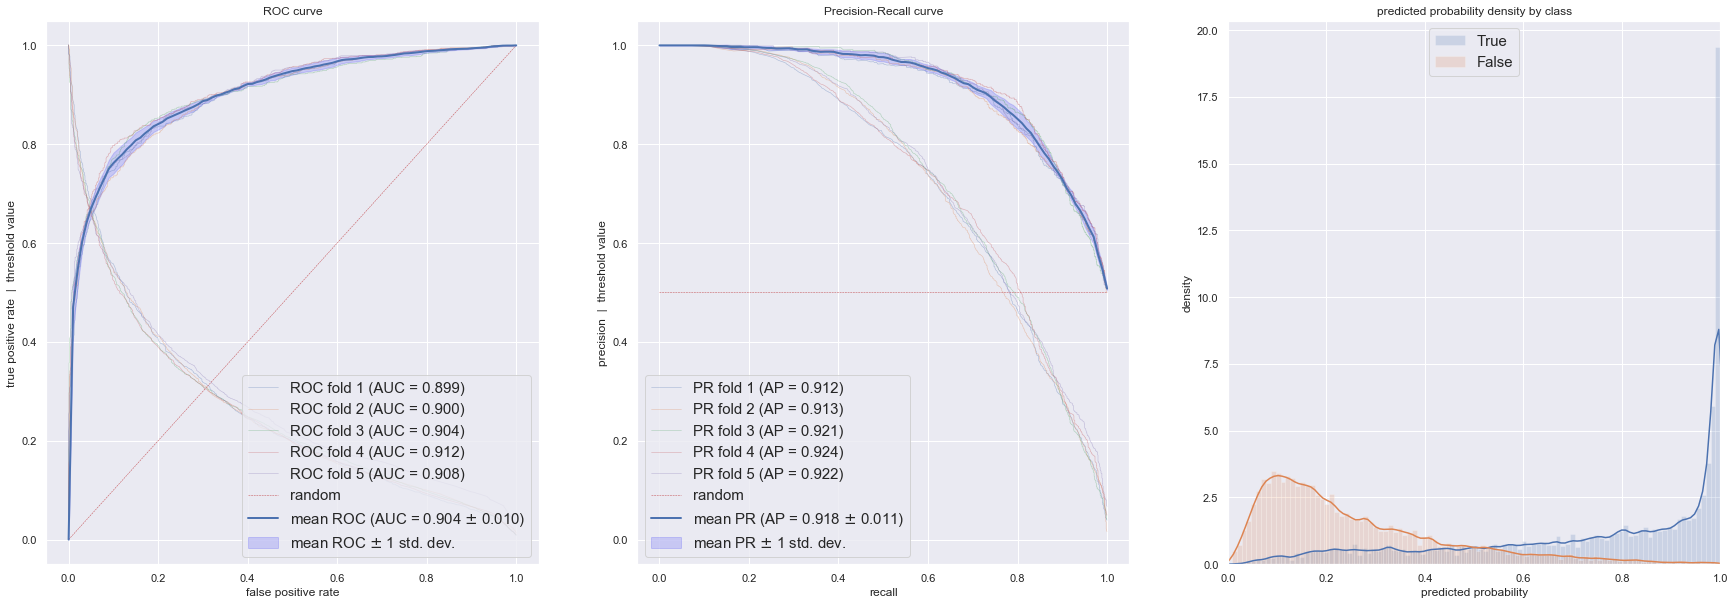

**RandomForest_unified_sampling_3**

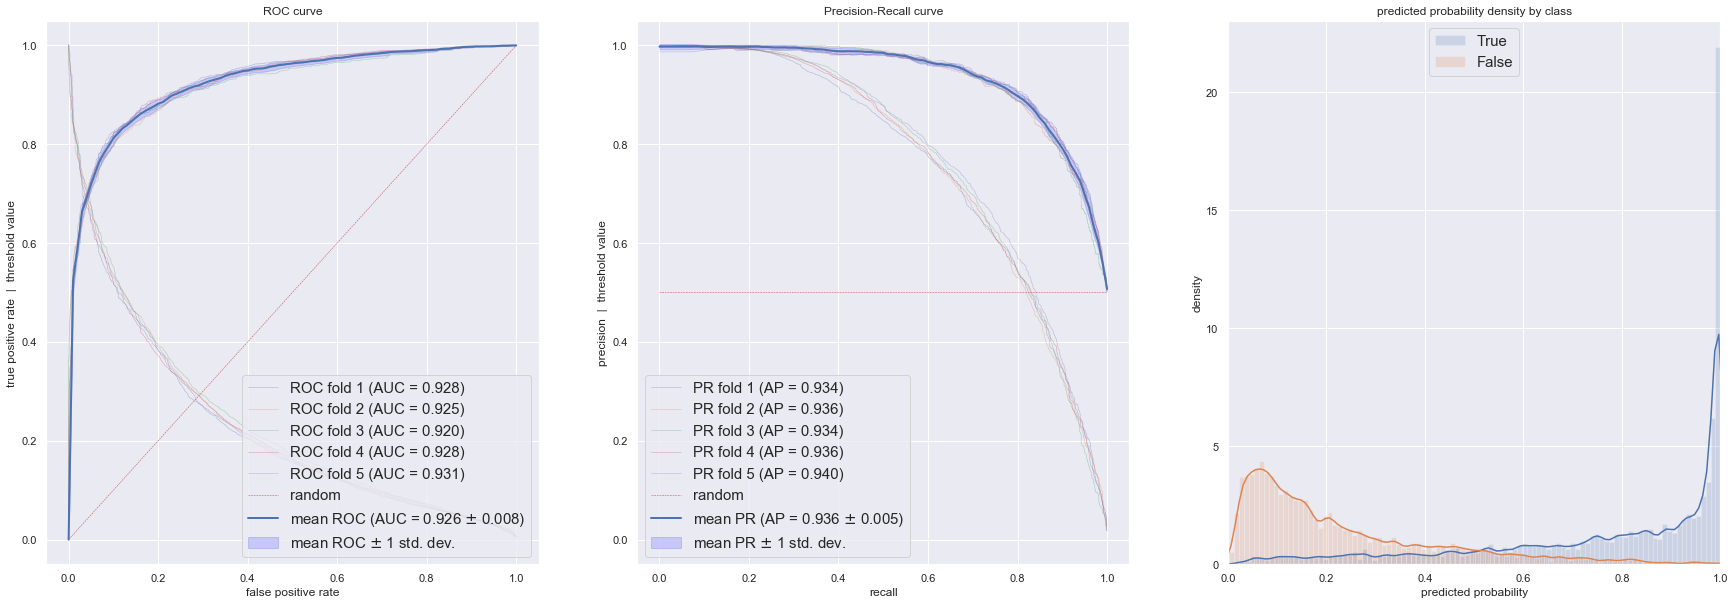

In [31]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_threshold_decision_metrics(job.metrics)
        plt.show()

**RandomForest_unified_sampling_1**

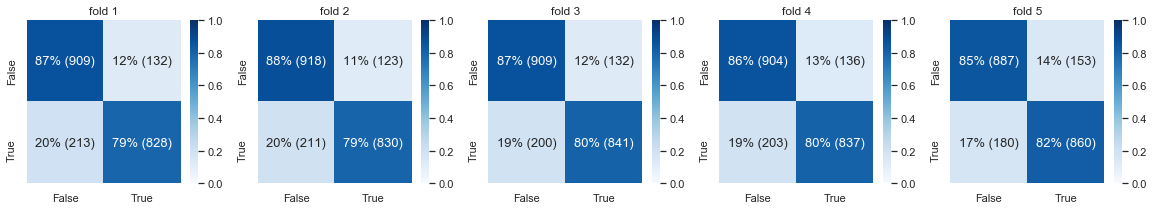

**RandomForest_unified_sampling_2**

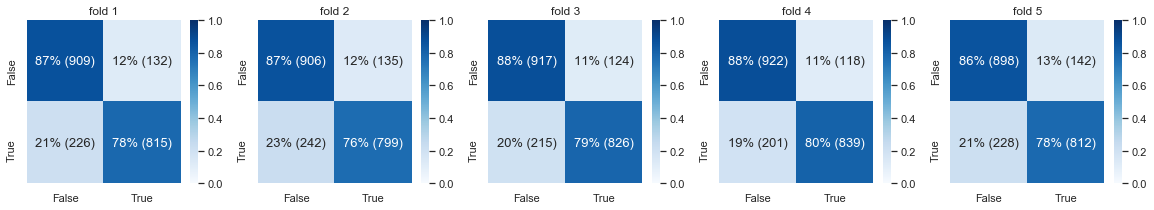

**RandomForest_unified_sampling_3**

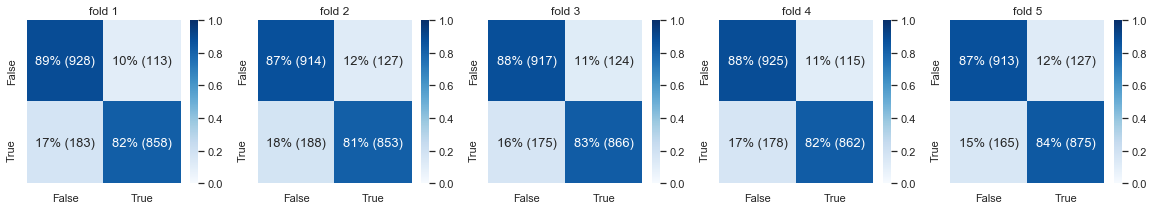

In [32]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_confusion_matrix(job.metrics)
        plt.show()

In [33]:
for job in job_list:
    if hasattr(job, 'metrics'):
        add_metrics_to_summary(summary, job.metrics, job.job_id)

### Study feature importance of the best hyperparameted classifier

**sampling_1**

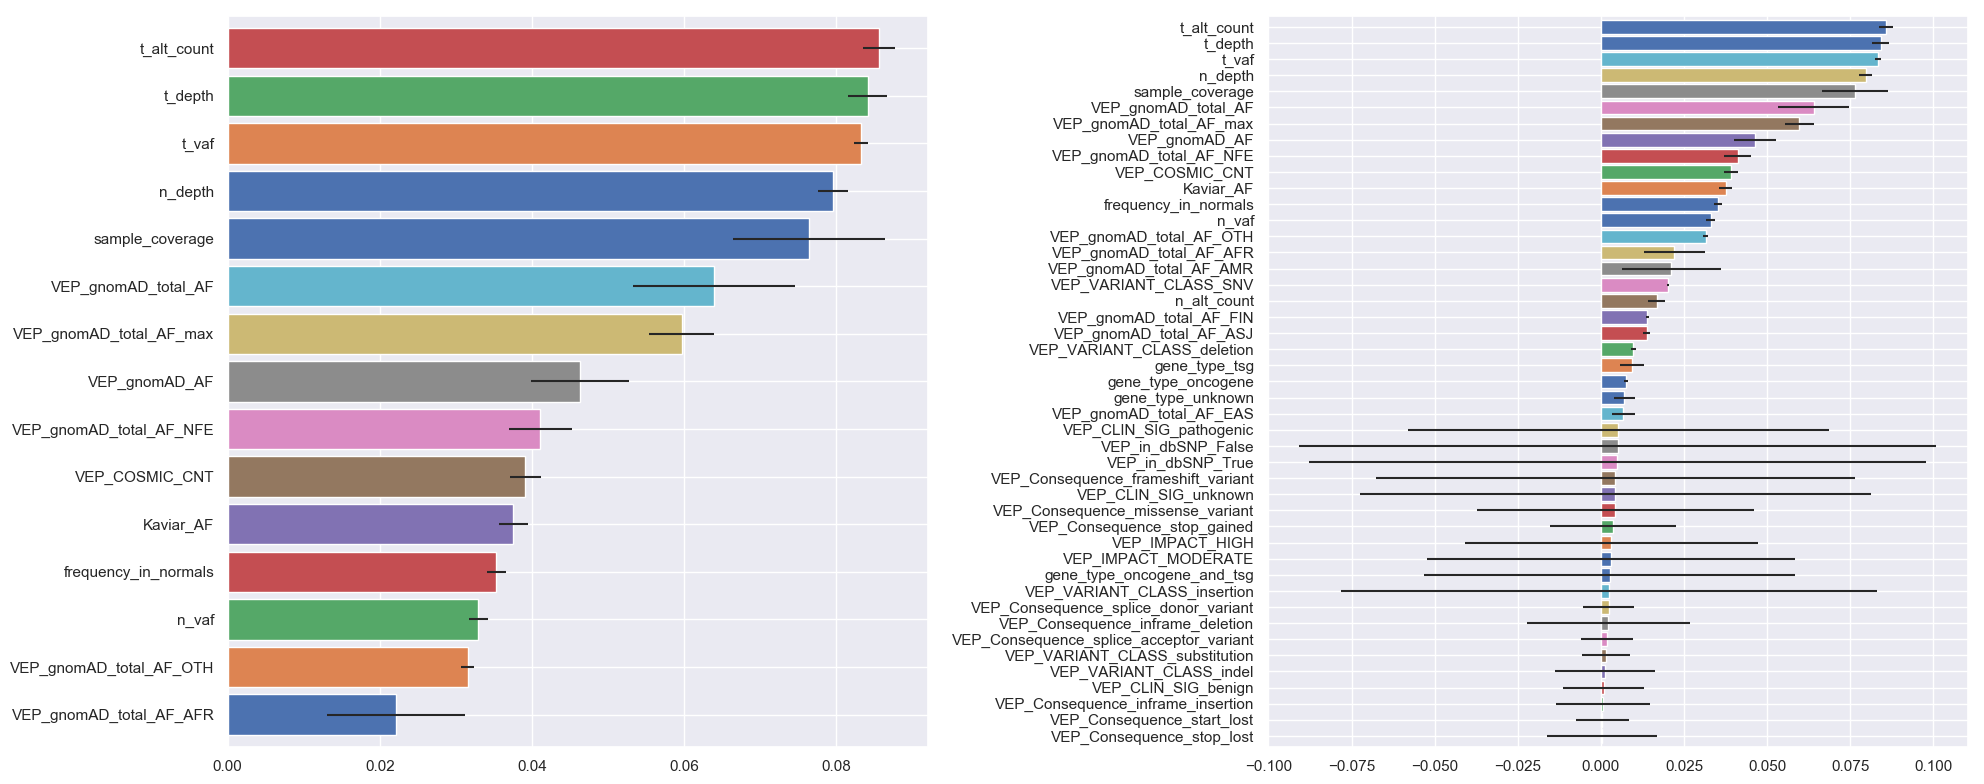

**sampling_2**

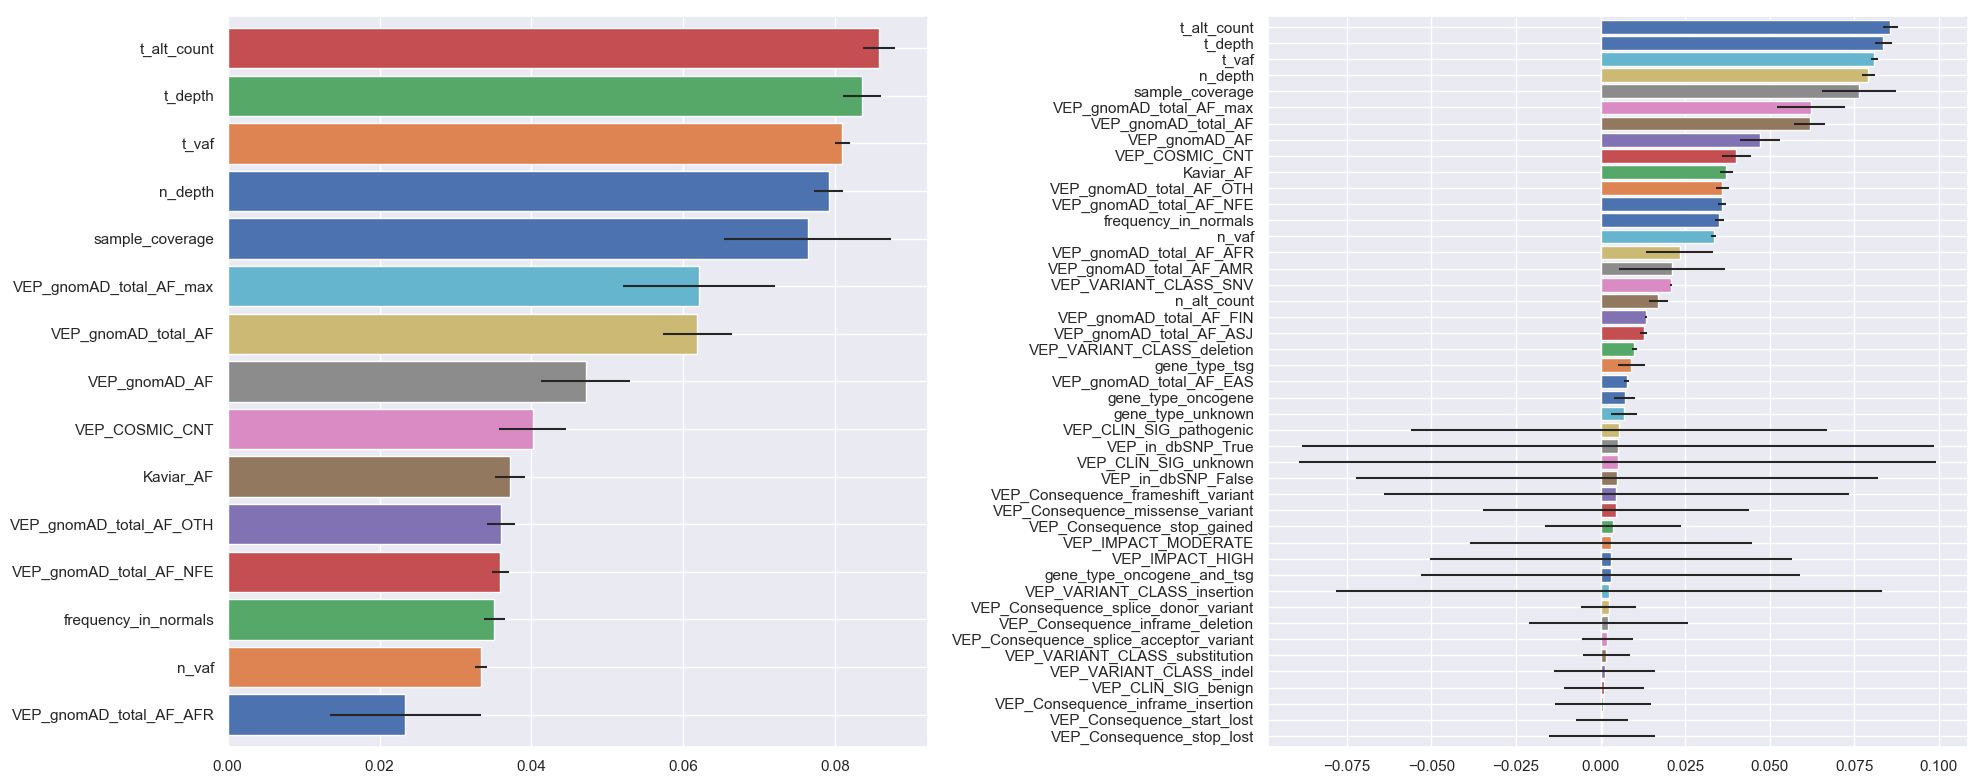

**sampling_3**

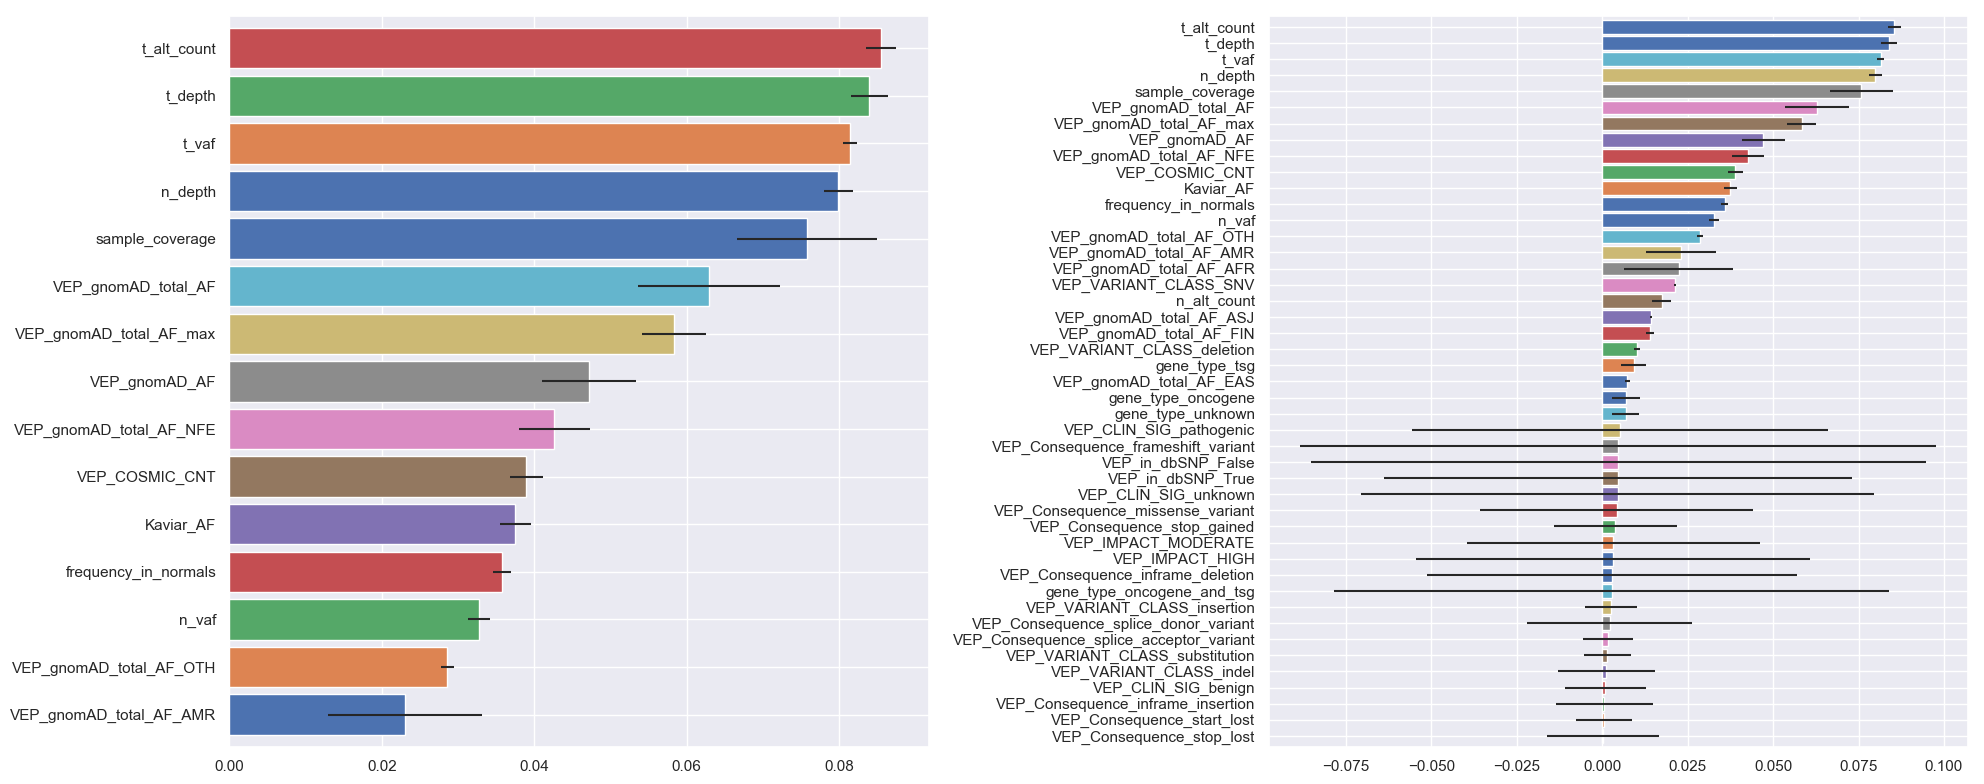

In [124]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5)

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_features_importance(model_bestRF, dataset_dict[key]['X'], dataset_dict[key]['y'], random_forest=True)
    plt.show()

## Summary

In [98]:
sampling_strategy_summary = Summary()
sampling_strategy_summary.load('sampling_strategy_summary.pkl')
# sampling_strategy_summary.save('sampling_strategy_summary.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'sampling_strategy_summary.pkl'

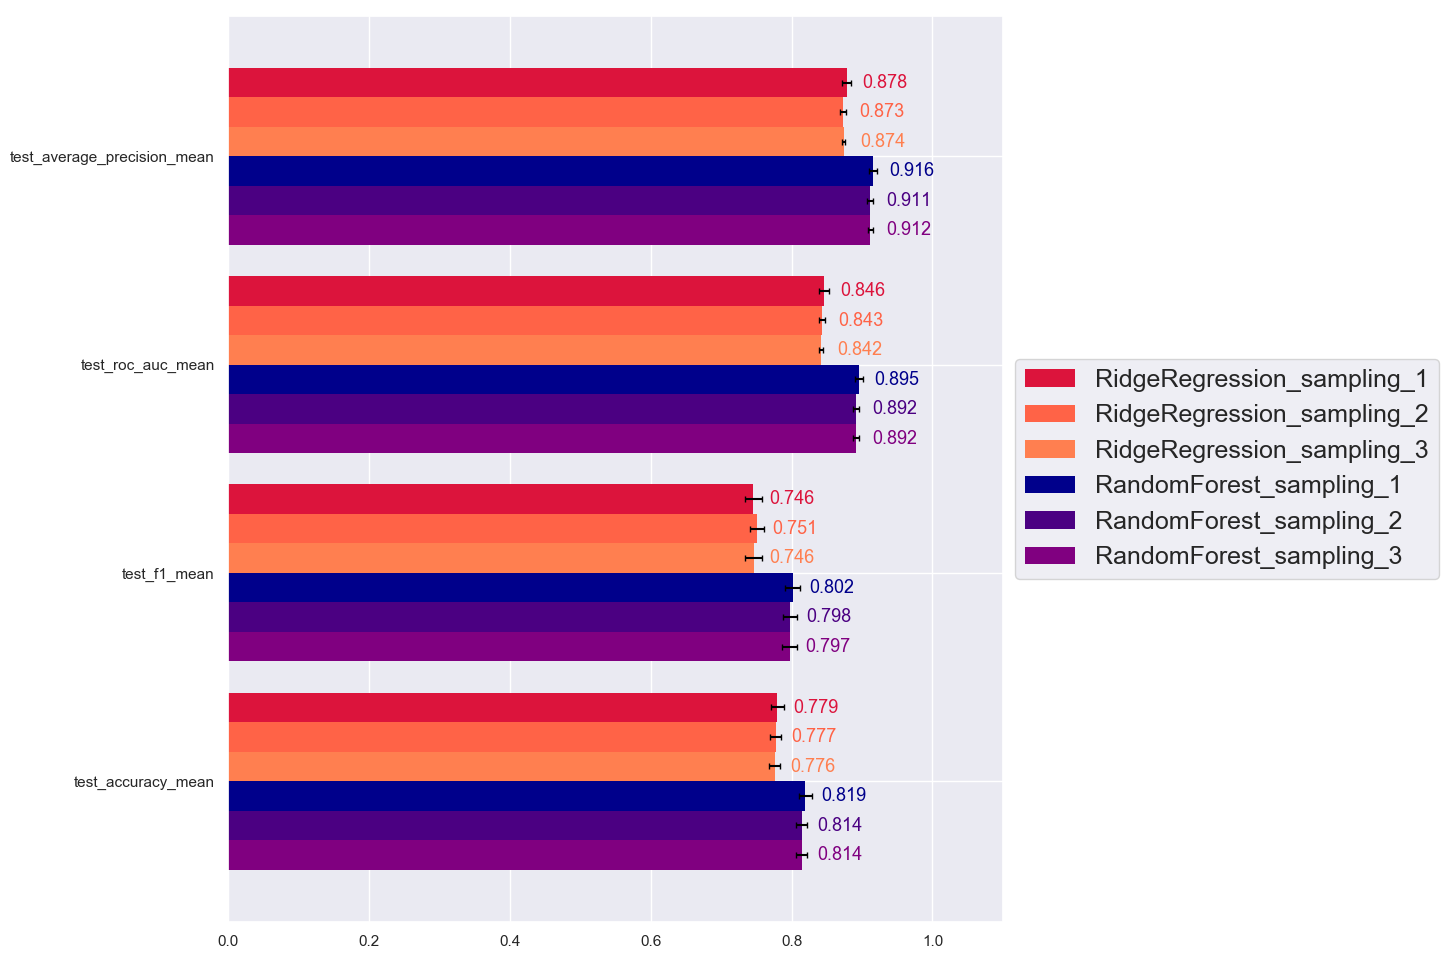

In [102]:
sampling_strategy_summary.display()
sampling_strategy_summary.plot()

In [59]:
summary = pd.read_pickle('summary_sampling_comparison.pkl')

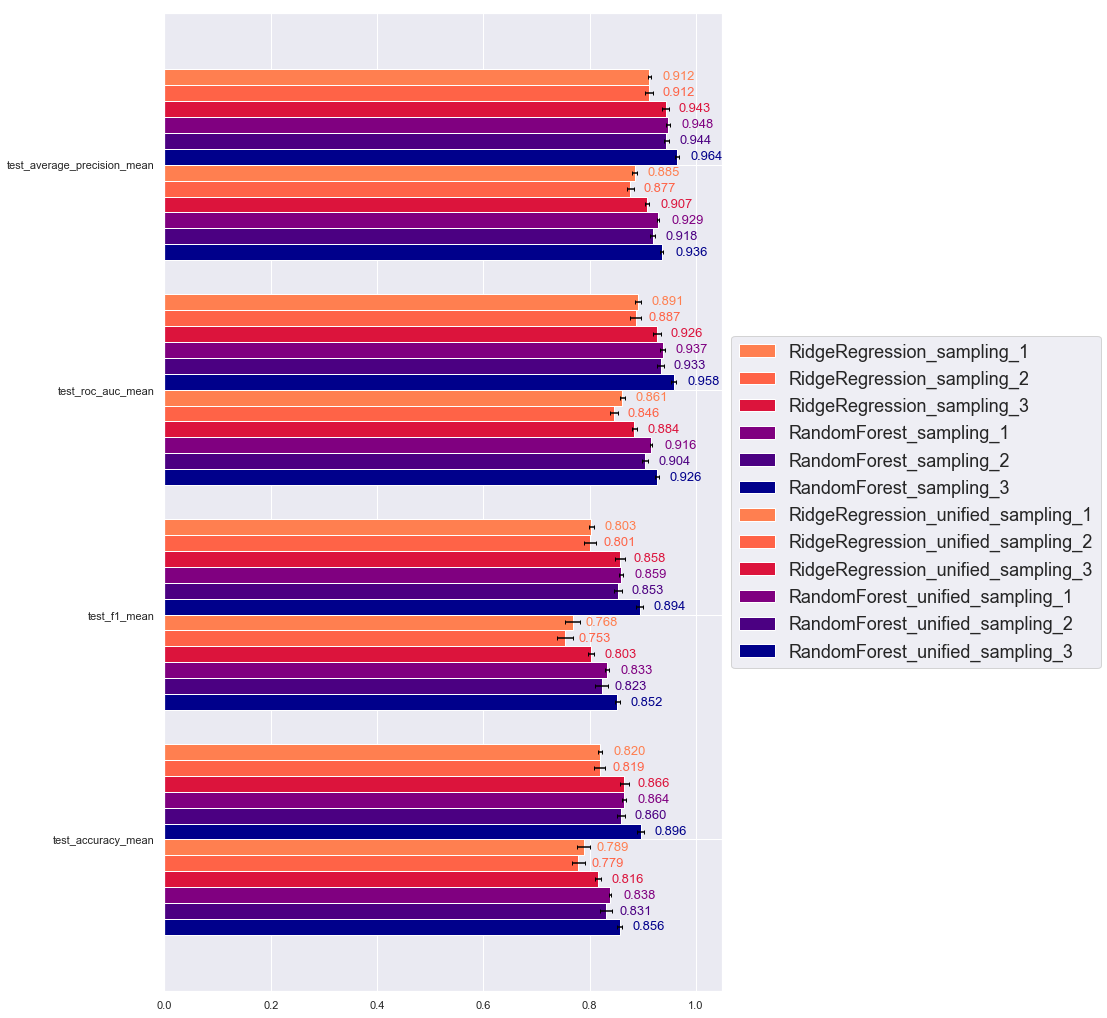

In [60]:
compare_models(summary, ['darkblue', 'indigo', 'purple', 'crimson', 'tomato', 'coral'], figsize=(10, 18))

In [58]:
summary.to_pickle('summary_sampling_comparison.pkl')

## Differences between sampling

In [3]:
def get_negative_class(seed):
    positive_class_number = impact[impact.is_artefact].shape[0]
    return impact[~impact.is_artefact].iloc[seed * positive_class_number:(seed + 1) * positive_class_number]

In [4]:
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
    
sampling_1 = get_negative_class(0)
sampling_2 = get_negative_class(1)
sampling_3 = get_negative_class(2)

sampling_1['sampling'] = 'sampling_1'
sampling_2['sampling'] = 'sampling_2'
sampling_3['sampling'] = 'sampling_3'
data = pd.concat([sampling_1, sampling_2, sampling_3])

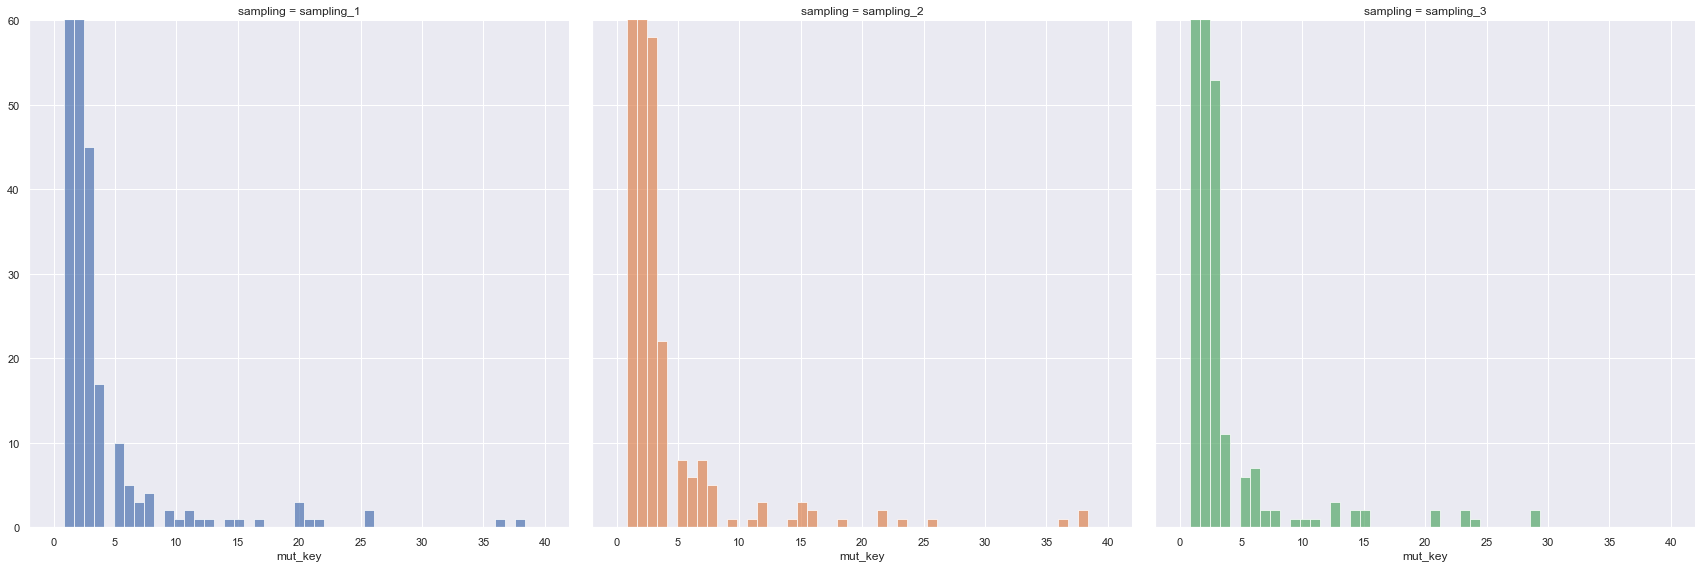

In [5]:
aggregation = {
    'mut_key': 'count',
    'sampling': lambda x: x.iloc[0]
}

grid = seaborn.FacetGrid(data.groupby(['sampling', 'mut_key']).aggregate(aggregation), col='sampling', hue='sampling', margin_titles=True, height=8)
grid.map(plt.hist, 'mut_key', bins=np.linspace(0, 40, 50), alpha=0.7)
plt.ylim(0, 60);

/Users/guilminp/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


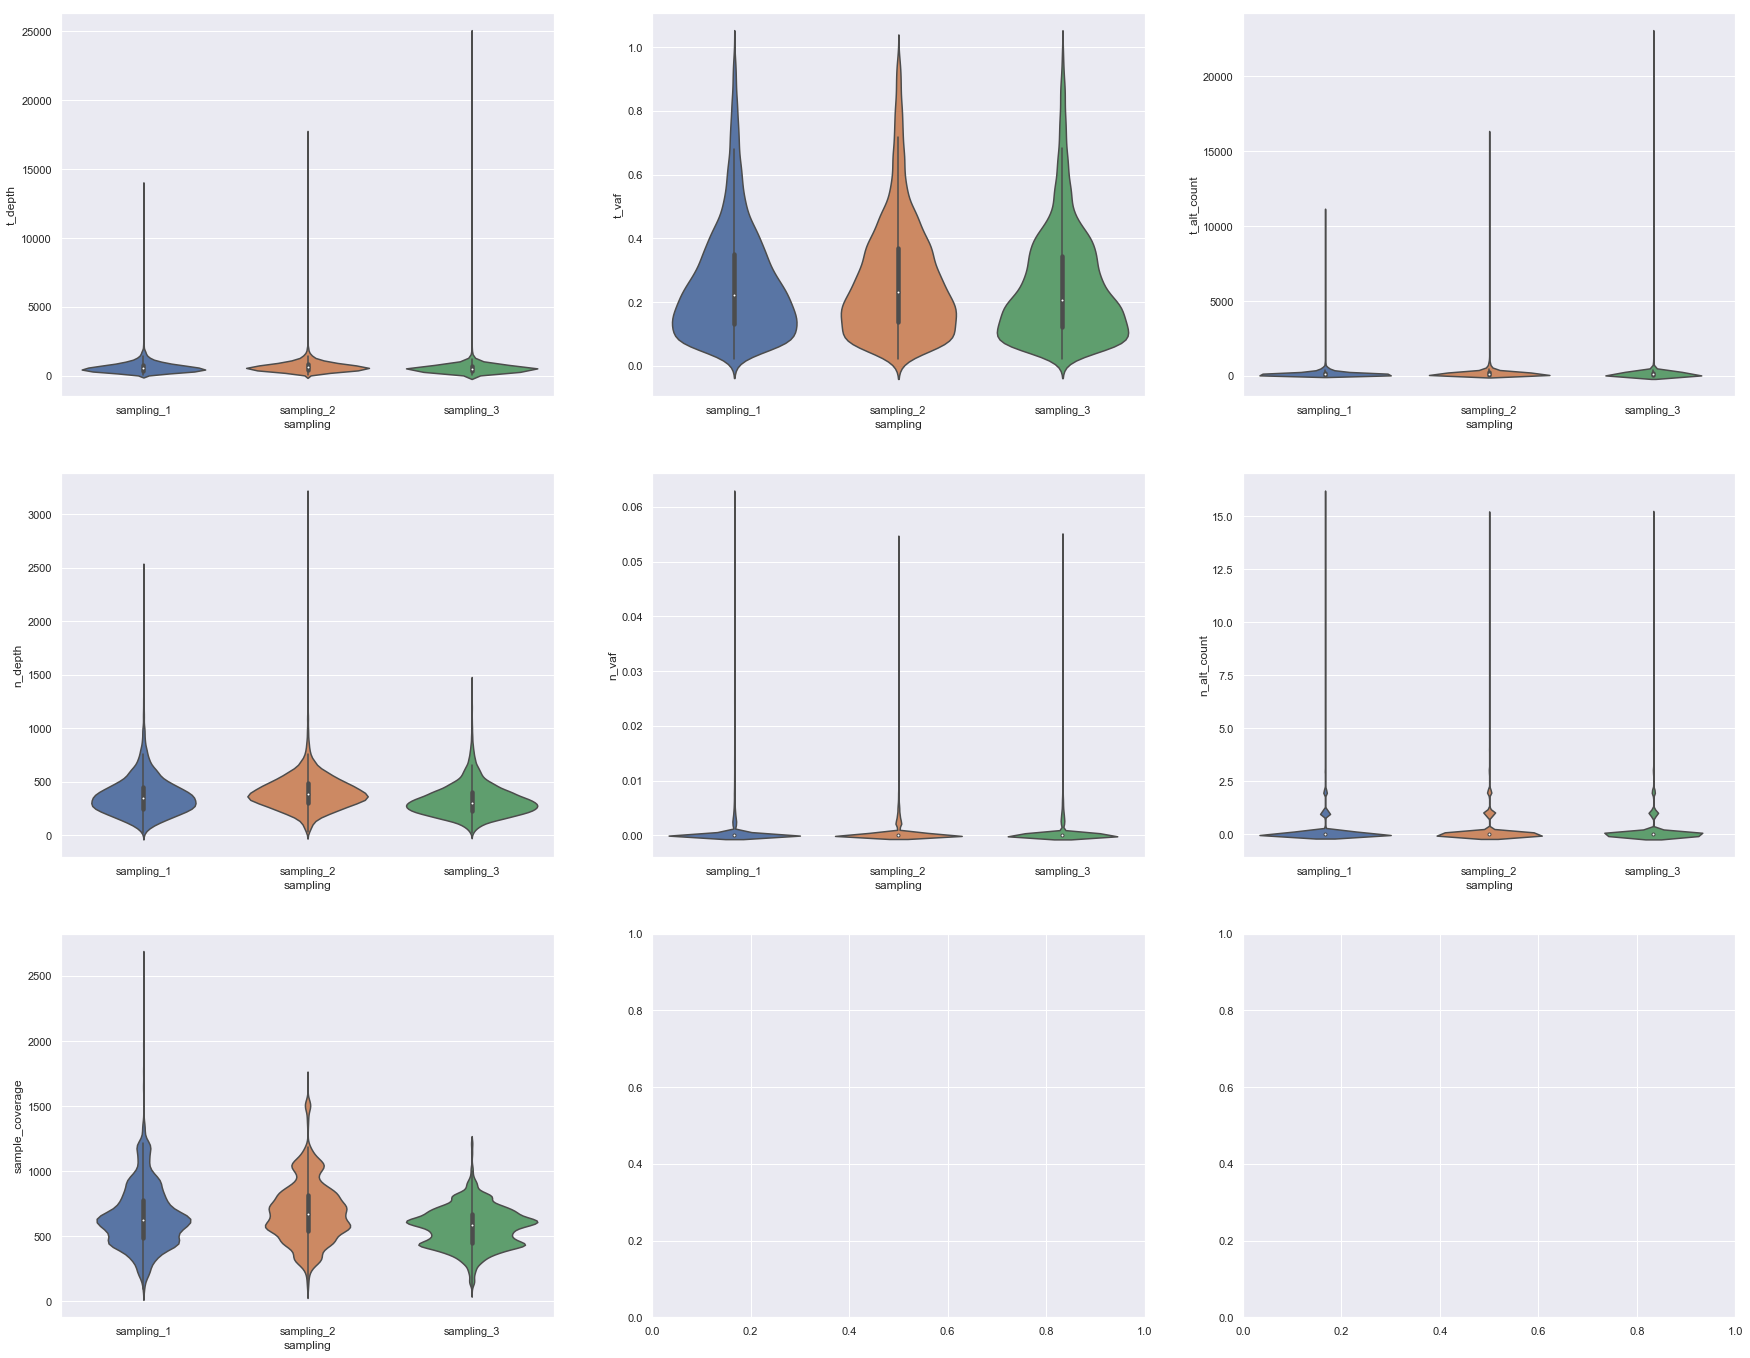

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(30, 24))

for i, feature in enumerate(['t_depth', 't_vaf', 't_alt_count',
                             'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage']):
    #seaborn.catplot(data=data, x='sampling', y=feature, kind='box', flierprops={'marker': 'o', 'markersize': 3}, ax=ax[i // 3, i % 3]);
    seaborn.catplot(data=data, x='sampling', y=feature, kind='violin', ax=ax[i // 3, i % 3])
    plt.close(2)

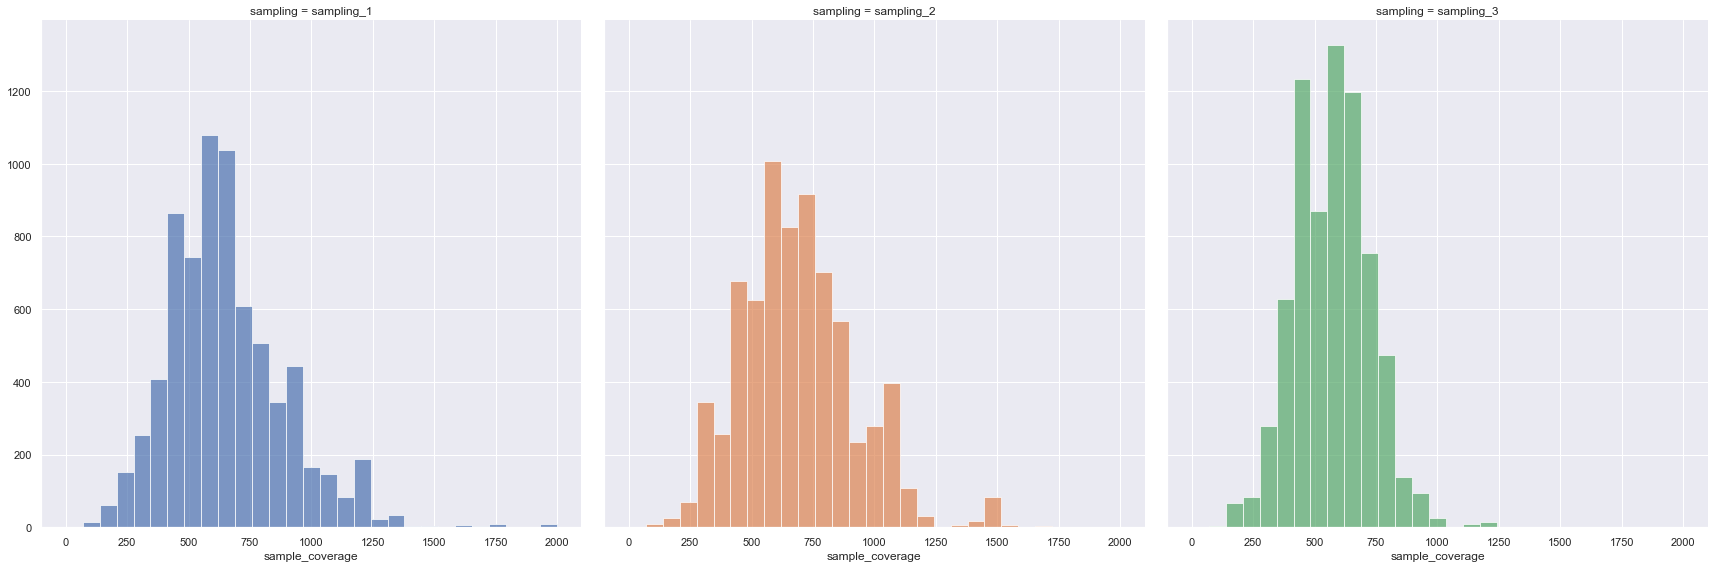

In [7]:
grid = seaborn.FacetGrid(data, col='sampling', hue='sampling', margin_titles=True, height=8)
grid.map(plt.hist, 'sample_coverage', bins=np.linspace(0, 2000, 30), alpha=0.7);

In [8]:
data[data.frequency_in_normals > 0]

Empty DataFrame
Columns: [Hugo_Symbol, Chromosome, Start_Position, End_Position, Consequence, Variant_Type, Reference_Allele, Tumor_Seq_Allele2, Tumor_Sample_Barcode, cDNA_change, HGVSp_Short, t_depth, t_vaf, t_alt_count, n_depth, n_vaf, n_alt_count, t_ref_plus_count, t_ref_neg_count, t_alt_plus_count, t_alt_neg_count, confidence_class, sample_coverage, mut_key, VAG_VT, VAG_GENE, VAG_cDNA_CHANGE, VAG_PROTEIN_CHANGE, VAG_EFFECT, VEP_Consequence, VEP_SYMBOL, VEP_HGVSc, VEP_HGVSp, VEP_Amino_acids, VEP_VARIANT_CLASS, VEP_EXON, VEP_INTRON, VEP_IMPACT, VEP_CLIN_SIG, VEP_COSMIC_CNT, VEP_gnomAD_AF, sample_mut_key, patient_key, frequency_in_normals, VEP_SIFT_class, VEP_SIFT_score, VEP_PolyPhen_class, VEP_PolyPhen_score, VEP_in_dbSNP, VEP_gnomAD_total_AF_AFR, VEP_gnomAD_total_AF_AMR, VEP_gnomAD_total_AF_ASJ, VEP_gnomAD_total_AF_EAS, VEP_gnomAD_total_AF_FIN, VEP_gnomAD_total_AF_NFE, VEP_gnomAD_total_AF_OTH, VEP_gnomAD_total_AF_max, VEP_gnomAD_total_AF, Kaviar_AF, is_a_hotspot, is_a_3d_hotspot, oncogenic, gene_type, is_artefact, sampling]
Index: []

/Users/guilminp/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


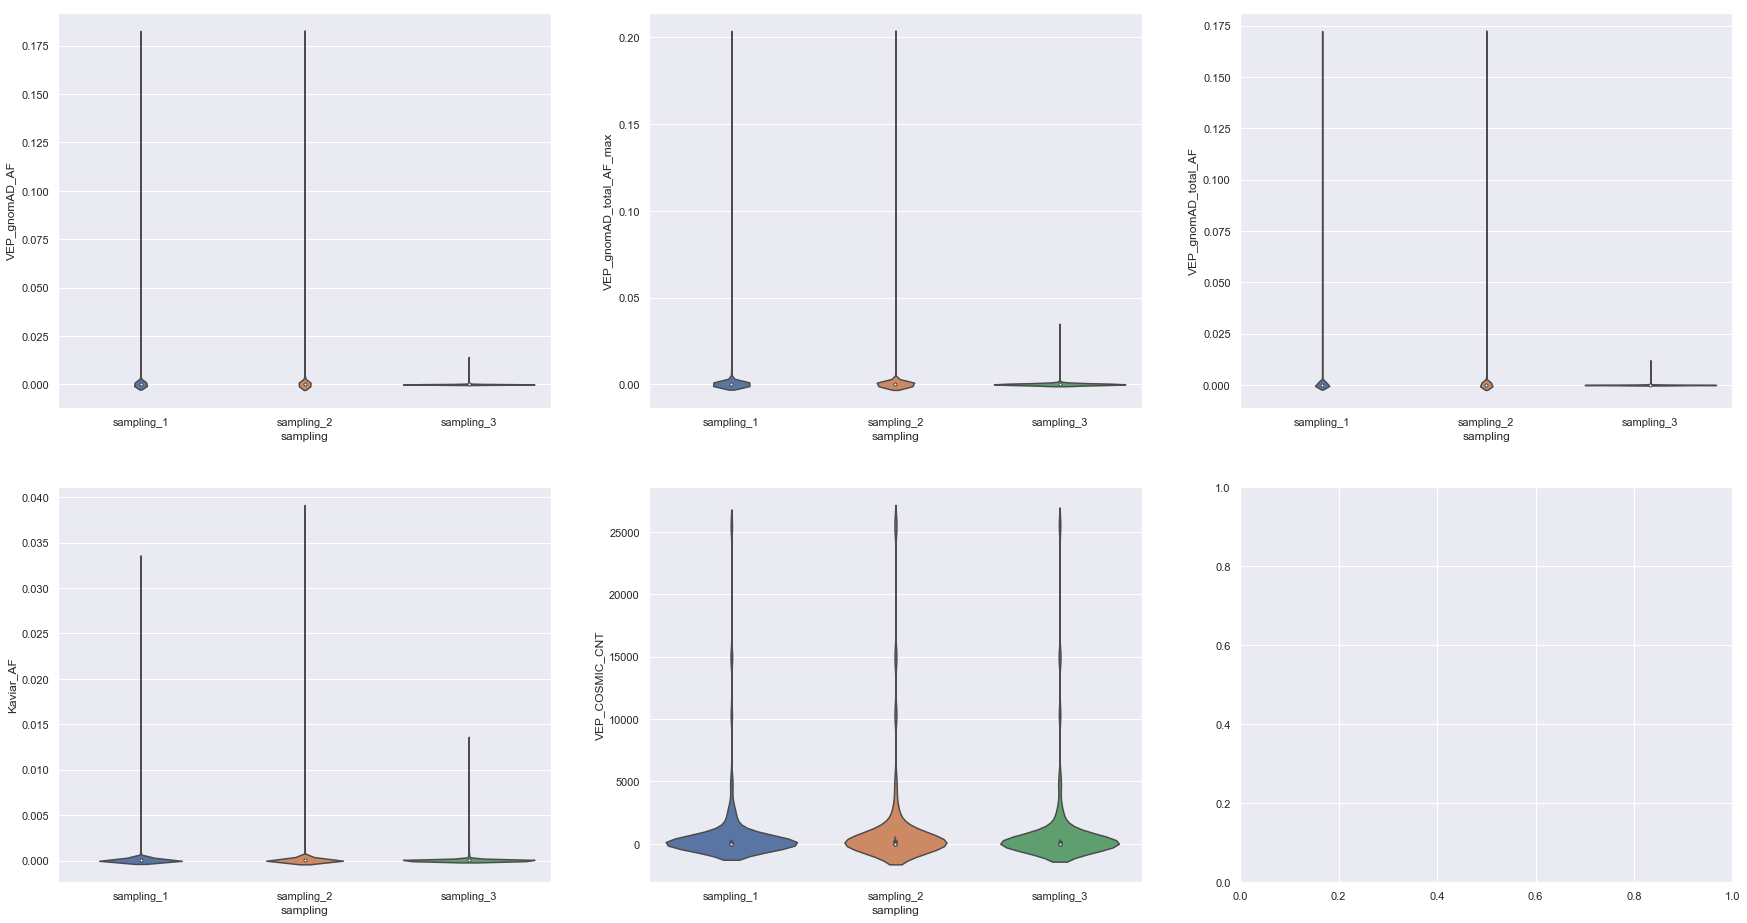

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(30, 16))
for i, feature in enumerate(['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
                             'Kaviar_AF', 'VEP_COSMIC_CNT']):
    seaborn.catplot(data=data[data[feature] > 0], x='sampling', y=feature, kind='violin', ax=ax[i // 3, i % 3])
    plt.close(2)

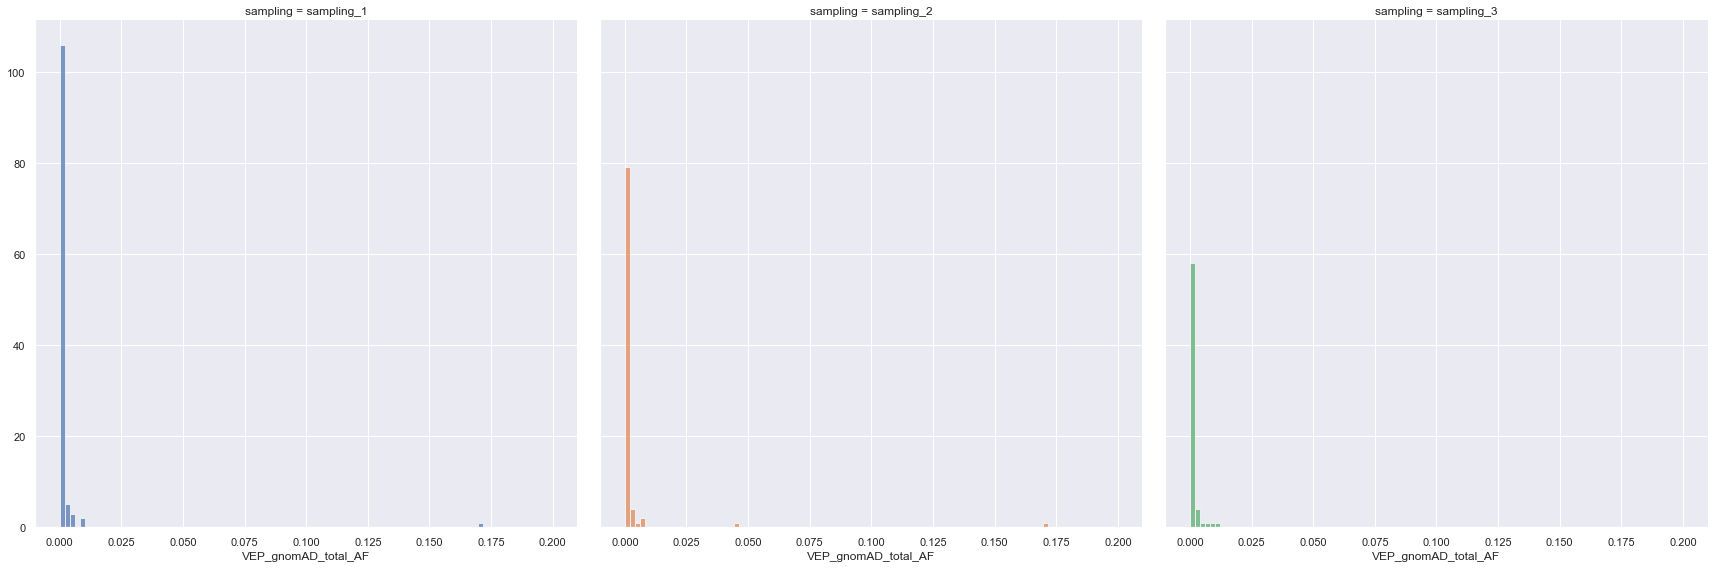

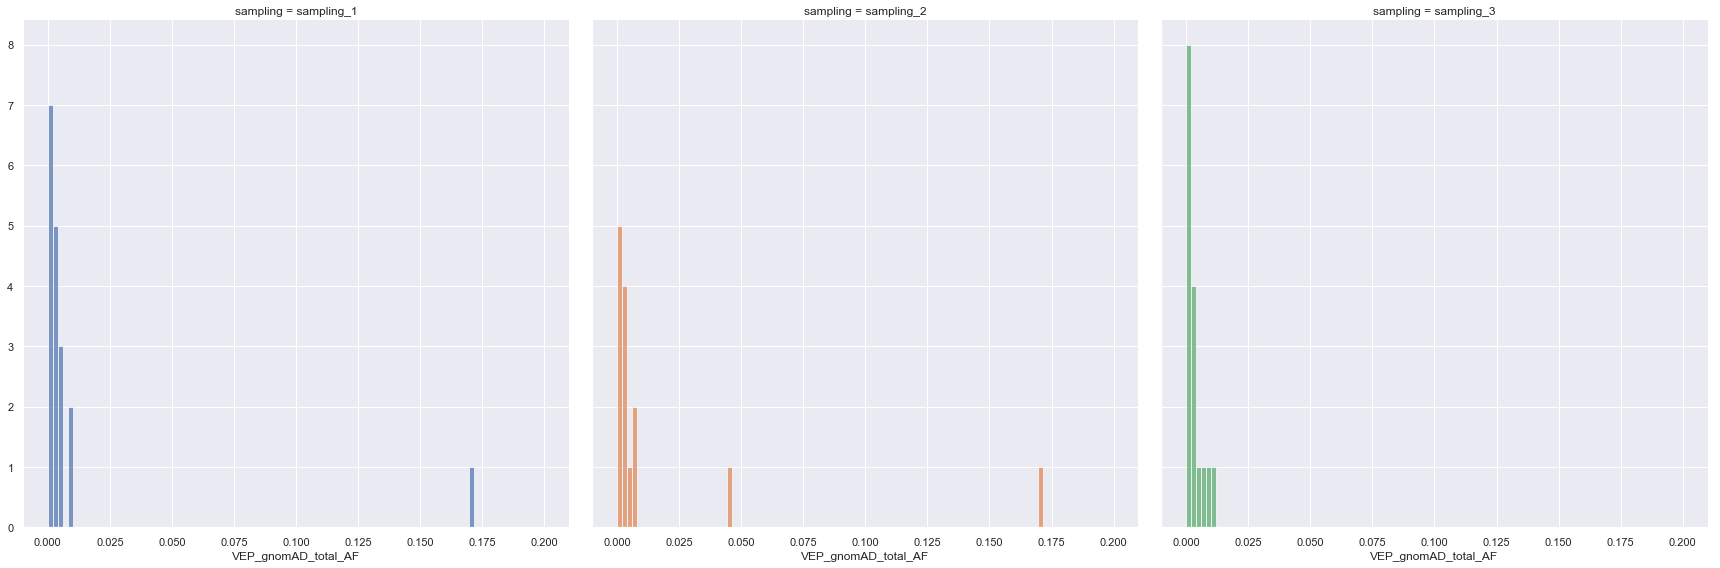

In [10]:
grid = seaborn.FacetGrid(data[data.VEP_gnomAD_total_AF > 0.0001], col='sampling', hue='sampling', margin_titles=True, height=8)
grid.map(plt.hist, 'VEP_gnomAD_total_AF', bins=np.linspace(0, 0.2, 100), alpha=0.7)
grid = seaborn.FacetGrid(data[data.VEP_gnomAD_total_AF > 0.001], col='sampling', hue='sampling', margin_titles=True, height=8)
grid.map(plt.hist, 'VEP_gnomAD_total_AF', bins=np.linspace(0, 0.2, 100), alpha=0.7);

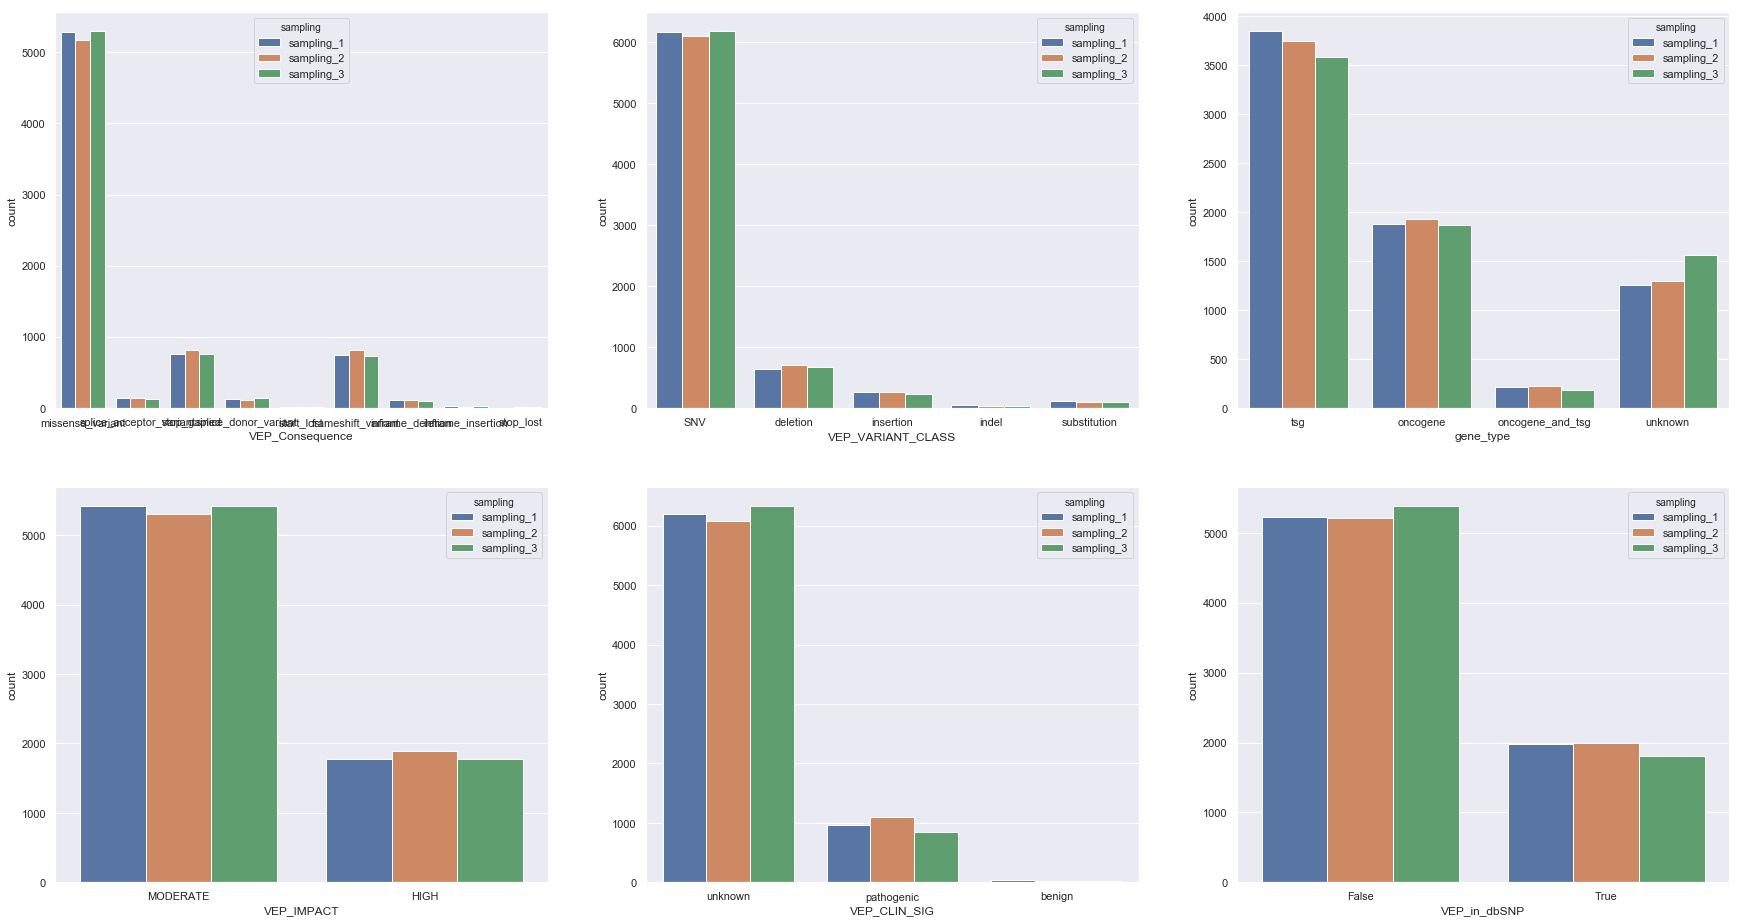

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(30, 16))
for i, feature in enumerate(['VEP_Consequence', 'VEP_VARIANT_CLASS', 'gene_type',
                             'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP']):
    seaborn.catplot(data=data, hue='sampling', x=feature, kind='count', ax=ax[i // 3, i % 3])
    plt.close(2)

# Test

In [2]:
%run ../ml_tools.py

In [3]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']

# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)
impact = get_impact_ready_for_classification(impact, 'is_artefact', features)

In [4]:
X, y = get_X_and_y(impact, 'is_artefact', 'all')
print(X.shape)
print(y.shape)
display(get_table(y))

(194211, 45)
(194211,)


count_  freq_
False  187012  96.3%
True     7199   3.7%

In [5]:
def get_seeded_negative_class_X_and_y(impact, label, seed):
    positive_class_number = impact[impact.is_artefact].shape[0]

    X, y = get_X_and_y(impact, label, range(seed * positive_class_number, (seed + 1) * positive_class_number))
    print(X.shape)
    print(y.shape)
    display(get_table(y))
    
    return X, y

X_1, y_1 = get_seeded_negative_class_X_and_y(impact, 'is_artefact', 0)

(14398, 45)
(14398,)


count_  freq_
True     7199  50.0%
False    7199  50.0%

## GaussianNB

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', GaussianNB())])
metrics_CV = run_model(model, X_1, y_1, cv_strategy)
print_mean_metrics(metrics_CV)

Run model... done! (0.94s)
▴ Mean accuracy    : 0.707 ± 0.032
▴ Mean ROC AUC     : 0.823 ± 0.016
▴ Mean F1-score    : 0.595 ± 0.062
▴ Average precision: 0.844 ± 0.019


In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=12),
                      StandardScaler(),
                      GaussianNB())
metrics_CV_sample = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics_CV_sample)

Run model... done! (12.95s)
▴ Mean accuracy    : 0.961 ± 0.004
▴ Mean ROC AUC     : 0.822 ± 0.014
▴ Mean F1-score    : 0.452 ± 0.024
▴ Average precision: 0.310 ± 0.039


In [11]:
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score

metrics_CV_sample_manual = pd.DataFrame(index=range(cv_strategy.get_n_splits()),
                           columns=['fit_time', 'score_time',
                                    'test_accuracy', 'train_accuracy',
                                    'test_roc_auc', 'train_roc_auc',
                                    'test_f1', 'train_f1',
                                    'test_average_precision', 'train_average_precision',
                                    'estimator', 'confusion_matrix'])
metrics_CV_sample_manual.index.name = 'fold_number'

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', GaussianNB())])


sampler = RandomUnderSampler(ratio='majority', random_state=12)

for i, (train_index, test_index) in enumerate(cv_strategy.split(X, y)):
    print('  - fold %d/%d...' % (i + 1, cv_strategy.get_n_splits()))
    (X_train, X_test) = (X.iloc[train_index], X.iloc[test_index])
    (y_train, y_test) = (y.iloc[train_index], y.iloc[test_index])
    
    #print('Before sampling: X%r | y%r' % (X_train.shape, y_train.shape))
    #display(get_table(y_train))
    X_train, y_train = sampler.fit_sample(X_train, y_train)
    #print('After sampling : X%r | y%r' % (X_train.shape, y_train.shape))
    #display(get_table(pd.Series(y_train)))
    
    model.fit(X_train, y_train)
    
    #print('Before sampling: X%r | y%r' % (X_test.shape, y_test.shape))
    #display(get_table(y_test))
    X_test, y_test = sampler.fit_sample(X_test, y_test)
    #print('After sampling : X%r | y%r' % (X_test.shape, y_test.shape))
    #display(get_table(pd.Series(y_test)))
    
    y_test_pred  = model.predict_proba(X_test) [:, 1]
    
    metrics_CV_sample_manual.iloc[i].test_accuracy           = np.mean(model.predict(X_test)  == y_test)
    metrics_CV_sample_manual.iloc[i].test_roc_auc            = roc_auc_score(y_test, y_test_pred)
    metrics_CV_sample_manual.iloc[i].test_f1                 = f1_score(y_test,  model.predict(X_test))
    metrics_CV_sample_manual.iloc[i].test_average_precision  = average_precision_score(y_test, y_test_pred)
    metrics_CV_sample_manual.iloc[i]['confusion_matrix'] = confusion_matrix(y_test, model.predict(X_test))
    
    #print('Accuracy: %.3f' % (np.mean(model.predict(X_test)  == y_test)))
    #print('AP      : %.3f' % (average_precision_score(y_test, y_test_pred)))
    #print()

  - fold 1/5...
  - fold 2/5...
  - fold 3/5...
  - fold 4/5...
  - fold 5/5...


In [12]:
print_mean_metrics(metrics_CV)
print()
print_mean_metrics(metrics_CV_sample)
print()
print_mean_metrics(metrics_CV_sample_manual)

▴ Mean accuracy    : 0.707 ± 0.032
▴ Mean ROC AUC     : 0.823 ± 0.016
▴ Mean F1-score    : 0.595 ± 0.062
▴ Average precision: 0.844 ± 0.019

▴ Mean accuracy    : 0.961 ± 0.004
▴ Mean ROC AUC     : 0.822 ± 0.014
▴ Mean F1-score    : 0.452 ± 0.024
▴ Average precision: 0.310 ± 0.039

▴ Mean accuracy    : 0.706 ± 0.017
▴ Mean ROC AUC     : 0.820 ± 0.016
▴ Mean F1-score    : 0.593 ± 0.035
▴ Average precision: 0.844 ± 0.017


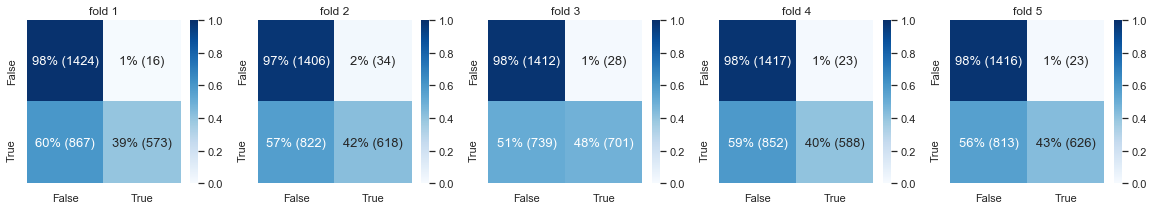

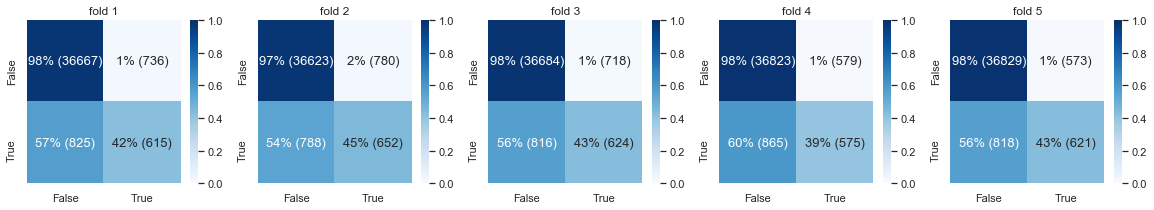

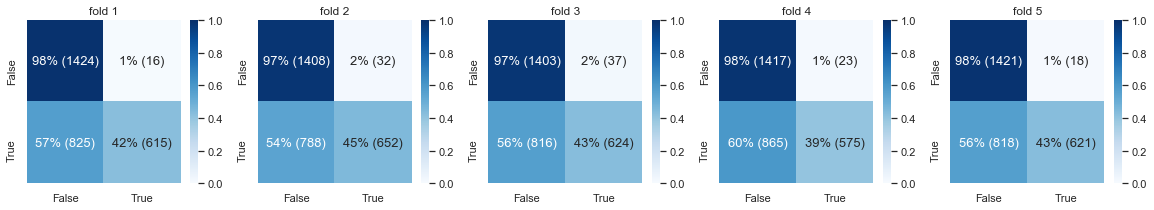

In [13]:
plot_confusion_matrix(metrics_CV)
plot_confusion_matrix(metrics_CV_sample)
plot_confusion_matrix(metrics_CV_sample_manual)

## LogistRegr

In [14]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42, max_iter=2000))])
metrics_CV = run_model(model, X_1, y_1, cv_strategy)
print_mean_metrics(metrics_CV)

Run model... done! (27.27s)
▴ Mean accuracy    : 0.778 ± 0.020
▴ Mean ROC AUC     : 0.847 ± 0.016
▴ Mean F1-score    : 0.744 ± 0.026
▴ Average precision: 0.879 ± 0.013


In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=12),
                      StandardScaler(),
                      LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42, max_iter=2000))
metrics_CV_sample = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics_CV_sample)

Run model... done! (31.72s)
▴ Mean accuracy    : 0.891 ± 0.018
▴ Mean ROC AUC     : 0.845 ± 0.011
▴ Mean F1-score    : 0.309 ± 0.027
▴ Average precision: 0.496 ± 0.031


In [16]:
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score

metrics_CV_sample_manual = pd.DataFrame(index=range(cv_strategy.get_n_splits()),
                           columns=['fit_time', 'score_time',
                                    'test_accuracy', 'train_accuracy',
                                    'test_roc_auc', 'train_roc_auc',
                                    'test_f1', 'train_f1',
                                    'test_average_precision', 'train_average_precision',
                                    'estimator', 'confusion_matrix'])
metrics_CV_sample_manual.index.name = 'fold_number'


model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42, max_iter=2000))])

sampler = RandomUnderSampler(ratio='majority', random_state=12)

for i, (train_index, test_index) in enumerate(cv_strategy.split(X, y)):
    print('  - fold %d/%d...' % (i + 1, cv_strategy.get_n_splits()))
    (X_train, X_test) = (X.iloc[train_index], X.iloc[test_index])
    (y_train, y_test) = (y.iloc[train_index], y.iloc[test_index])
    
    #print('Before sampling: X%r | y%r' % (X_train.shape, y_train.shape))
    #display(get_table(y_train))
    X_train, y_train = sampler.fit_sample(X_train, y_train)
    #print('After sampling : X%r | y%r' % (X_train.shape, y_train.shape))
    #display(get_table(pd.Series(y_train)))
    
    model.fit(X_train, y_train)
    
    #print('Before sampling: X%r | y%r' % (X_test.shape, y_test.shape))
    #display(get_table(y_test))
    X_test, y_test = sampler.fit_sample(X_test, y_test)
    #print('After sampling : X%r | y%r' % (X_test.shape, y_test.shape))
    #display(get_table(pd.Series(y_test)))
    
    y_test_pred  = model.predict_proba(X_test) [:, 1]
    
    metrics_CV_sample_manual.iloc[i].test_accuracy           = np.mean(model.predict(X_test)  == y_test)
    metrics_CV_sample_manual.iloc[i].test_roc_auc            = roc_auc_score(y_test, y_test_pred)
    metrics_CV_sample_manual.iloc[i].test_f1                 = f1_score(y_test,  model.predict(X_test))
    metrics_CV_sample_manual.iloc[i].test_average_precision  = average_precision_score(y_test, y_test_pred)
    metrics_CV_sample_manual.iloc[i]['confusion_matrix'] = confusion_matrix(y_test, model.predict(X_test))
    
    #print('Accuracy: %.3f' % (np.mean(model.predict(X_test)  == y_test)))
    #print('AP      : %.3f' % (average_precision_score(y_test, y_test_pred)))
    #print()

  - fold 1/5...
  - fold 2/5...
  - fold 3/5...
  - fold 4/5...
  - fold 5/5...


In [17]:
print_mean_metrics(metrics_CV)
print()
print_mean_metrics(metrics_CV_sample)
print()
print_mean_metrics(metrics_CV_sample_manual)

▴ Mean accuracy    : 0.778 ± 0.020
▴ Mean ROC AUC     : 0.847 ± 0.016
▴ Mean F1-score    : 0.744 ± 0.026
▴ Average precision: 0.879 ± 0.013

▴ Mean accuracy    : 0.891 ± 0.018
▴ Mean ROC AUC     : 0.845 ± 0.011
▴ Mean F1-score    : 0.309 ± 0.027
▴ Average precision: 0.496 ± 0.031

▴ Mean accuracy    : 0.780 ± 0.013
▴ Mean ROC AUC     : 0.843 ± 0.011
▴ Mean F1-score    : 0.749 ± 0.022
▴ Average precision: 0.875 ± 0.010


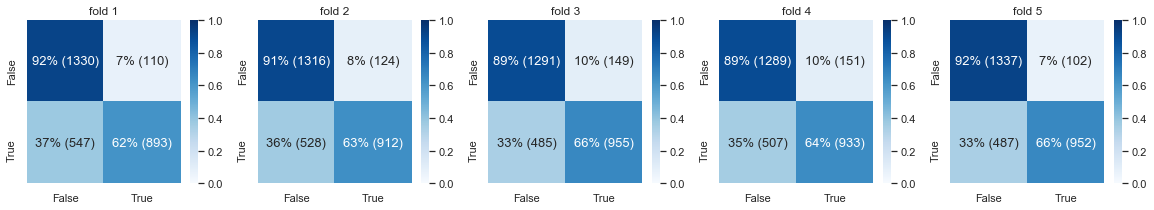

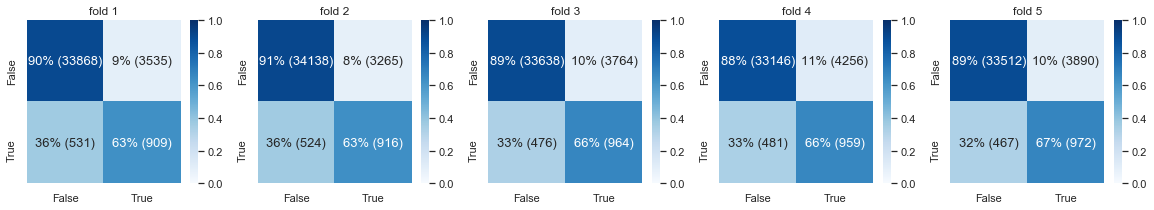

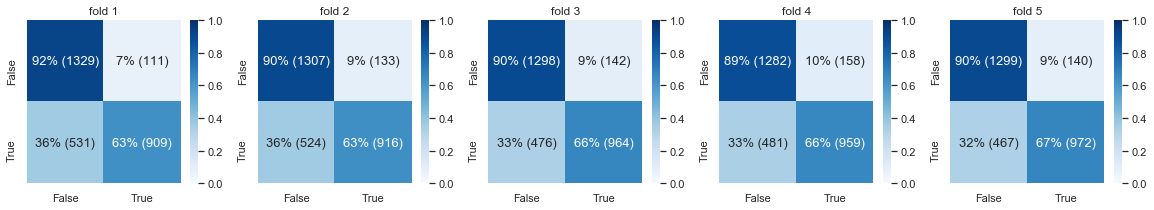

In [18]:
plot_confusion_matrix(metrics_CV)
plot_confusion_matrix(metrics_CV_sample)
plot_confusion_matrix(metrics_CV_sample_manual)

## RandomForest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=30, criterion='entropy', n_jobs=5)
metrics_CV = run_model(model, X_1, y_1, cv_strategy)
print_mean_metrics(metrics_CV)

Run model... done! (14.11s)
▴ Mean accuracy    : 0.818 ± 0.022
▴ Mean ROC AUC     : 0.895 ± 0.013
▴ Mean F1-score    : 0.803 ± 0.024
▴ Average precision: 0.915 ± 0.012


In [20]:
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=12, n_estimators=100, max_depth=30, criterion='entropy', n_jobs=5))
metrics_CV_sample = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics_CV_sample)

Run model... done! (90.77s)
▴ Mean accuracy    : 0.886 ± 0.010
▴ Mean ROC AUC     : 0.891 ± 0.013
▴ Mean F1-score    : 0.328 ± 0.014
▴ Average precision: 0.571 ± 0.025


In [21]:
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score

metrics_CV_sample_manual = pd.DataFrame(index=range(cv_strategy.get_n_splits()),
                           columns=['fit_time', 'score_time',
                                    'test_accuracy', 'train_accuracy',
                                    'test_roc_auc', 'train_roc_auc',
                                    'test_f1', 'train_f1',
                                    'test_average_precision', 'train_average_precision',
                                    'estimator', 'confusion_matrix'])
metrics_CV_sample_manual.index.name = 'fold_number'


model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=30, criterion='entropy', n_jobs=5)

sampler = RandomUnderSampler(ratio='majority', random_state=12)

for i, (train_index, test_index) in enumerate(cv_strategy.split(X, y)):
    print('  - fold %d/%d...' % (i + 1, cv_strategy.get_n_splits()))
    (X_train, X_test) = (X.iloc[train_index], X.iloc[test_index])
    (y_train, y_test) = (y.iloc[train_index], y.iloc[test_index])
    
    #print('Before sampling: X%r | y%r' % (X_train.shape, y_train.shape))
    #display(get_table(y_train))
    X_train, y_train = sampler.fit_sample(X_train, y_train)
    #print('After sampling : X%r | y%r' % (X_train.shape, y_train.shape))
    #display(get_table(pd.Series(y_train)))
    
    model.fit(X_train, y_train)
    
    #print('Before sampling: X%r | y%r' % (X_test.shape, y_test.shape))
    #display(get_table(y_test))
    X_test, y_test = sampler.fit_sample(X_test, y_test)
    #print('After sampling : X%r | y%r' % (X_test.shape, y_test.shape))
    #display(get_table(pd.Series(y_test)))
    
    y_test_pred  = model.predict_proba(X_test) [:, 1]
    
    metrics_CV_sample_manual.iloc[i].test_accuracy           = np.mean(model.predict(X_test)  == y_test)
    metrics_CV_sample_manual.iloc[i].test_roc_auc            = roc_auc_score(y_test, y_test_pred)
    metrics_CV_sample_manual.iloc[i].test_f1                 = f1_score(y_test,  model.predict(X_test))
    metrics_CV_sample_manual.iloc[i].test_average_precision  = average_precision_score(y_test, y_test_pred)
    metrics_CV_sample_manual.iloc[i]['confusion_matrix'] = confusion_matrix(y_test, model.predict(X_test))
    
    #print('Accuracy: %.3f' % (np.mean(model.predict(X_test)  == y_test)))
    #print('AP      : %.3f' % (average_precision_score(y_test, y_test_pred)))
    #print()

  - fold 1/5...
  - fold 2/5...
  - fold 3/5...
  - fold 4/5...
  - fold 5/5...


In [22]:
print_mean_metrics(metrics_CV)
print()
print_mean_metrics(metrics_CV_sample)
print()
print_mean_metrics(metrics_CV_sample_manual)

▴ Mean accuracy    : 0.818 ± 0.022
▴ Mean ROC AUC     : 0.895 ± 0.013
▴ Mean F1-score    : 0.803 ± 0.024
▴ Average precision: 0.915 ± 0.012

▴ Mean accuracy    : 0.886 ± 0.010
▴ Mean ROC AUC     : 0.891 ± 0.013
▴ Mean F1-score    : 0.328 ± 0.014
▴ Average precision: 0.571 ± 0.025

▴ Mean accuracy    : 0.817 ± 0.017
▴ Mean ROC AUC     : 0.891 ± 0.011
▴ Mean F1-score    : 0.802 ± 0.019
▴ Average precision: 0.911 ± 0.010


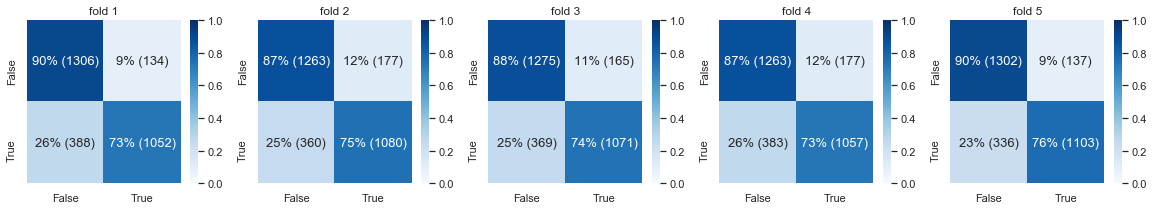

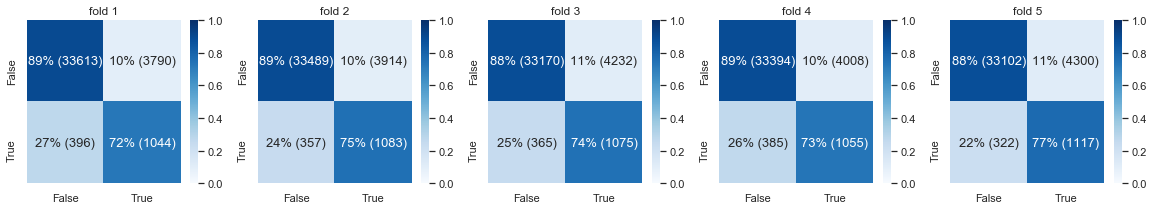

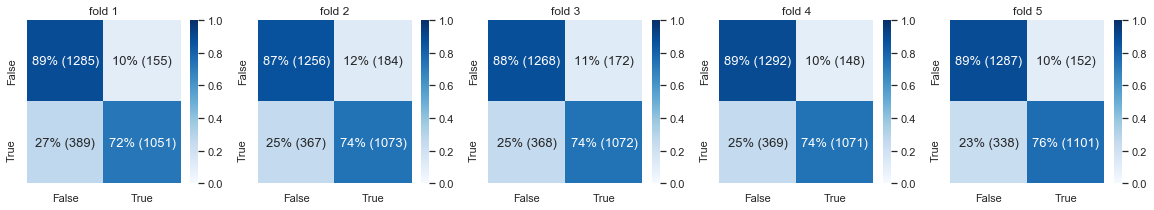

In [23]:
plot_confusion_matrix(metrics_CV)
plot_confusion_matrix(metrics_CV_sample)
plot_confusion_matrix(metrics_CV_sample_manual)

In [25]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42, max_iter=2000))])
metrics2 = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics2)

Run model... done! (37.62s)
▴ Mean accuracy    : 0.972 ± 0.001
▴ Mean ROC AUC     : 0.836 ± 0.014
▴ Mean F1-score    : 0.444 ± 0.019
▴ Average precision: 0.498 ± 0.025


In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=seed),
                      StandardScaler(),
                      LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))
    
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (7.59s)
▴ Mean accuracy    : 0.888 ± 0.016
▴ Mean ROC AUC     : 0.846 ± 0.010
▴ Mean F1-score    : 0.306 ± 0.015
▴ Average precision: 0.502 ± 0.021


In [22]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

metrics = []

for i, seed in enumerate([1, 23, 42, 56, 12]):
    print_md('**sample %d (seed = %s)**' % (i + 1, seed))
    
    model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=seed),
                          StandardScaler(),
                          LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))
    
    metrics.append(run_model(model, X, y, cv_strategy, n_jobs=5))
    print_mean_metrics(metrics[-1])
    
    add_metrics_to_summary(summary, metrics[-1], 'sample %d (seed = %s)' % (i + 1, seed))

**sample 1 (seed = 1)**

Run model... done! (7.48s)
▴ Mean accuracy    : 0.899 ± 0.015
▴ Mean ROC AUC     : 0.848 ± 0.013
▴ Mean F1-score    : 0.324 ± 0.031
▴ Average precision: 0.509 ± 0.026


**sample 2 (seed = 23)**

Run model... done! (8.37s)
▴ Mean accuracy    : 0.888 ± 0.031
▴ Mean ROC AUC     : 0.844 ± 0.011
▴ Mean F1-score    : 0.307 ± 0.052
▴ Average precision: 0.495 ± 0.028


**sample 3 (seed = 42)**

Run model... done! (8.14s)
▴ Mean accuracy    : 0.904 ± 0.008
▴ Mean ROC AUC     : 0.848 ± 0.013
▴ Mean F1-score    : 0.333 ± 0.013
▴ Average precision: 0.501 ± 0.028


**sample 4 (seed = 56)**

Run model... done! (7.83s)
▴ Mean accuracy    : 0.894 ± 0.010
▴ Mean ROC AUC     : 0.846 ± 0.014
▴ Mean F1-score    : 0.316 ± 0.025
▴ Average precision: 0.501 ± 0.027


**sample 5 (seed = 12)**

Run model... done! (8.65s)
▴ Mean accuracy    : 0.888 ± 0.016
▴ Mean ROC AUC     : 0.846 ± 0.010
▴ Mean F1-score    : 0.306 ± 0.015
▴ Average precision: 0.502 ± 0.021


**sample 1**

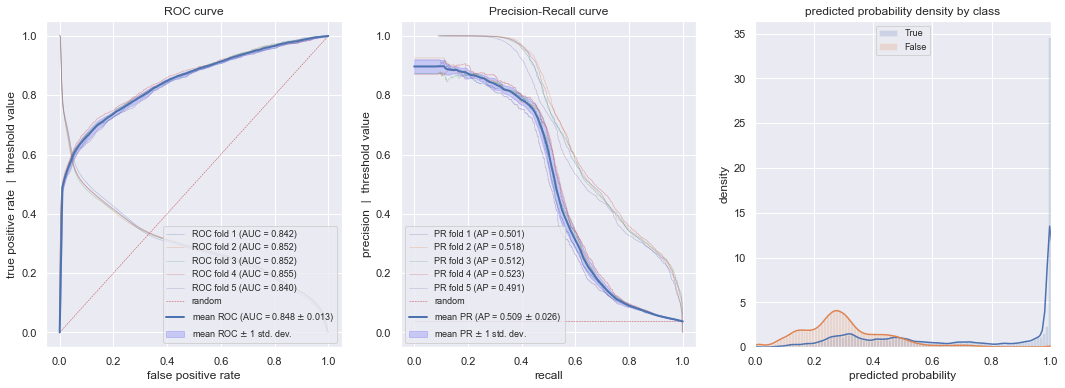

**sample 2**

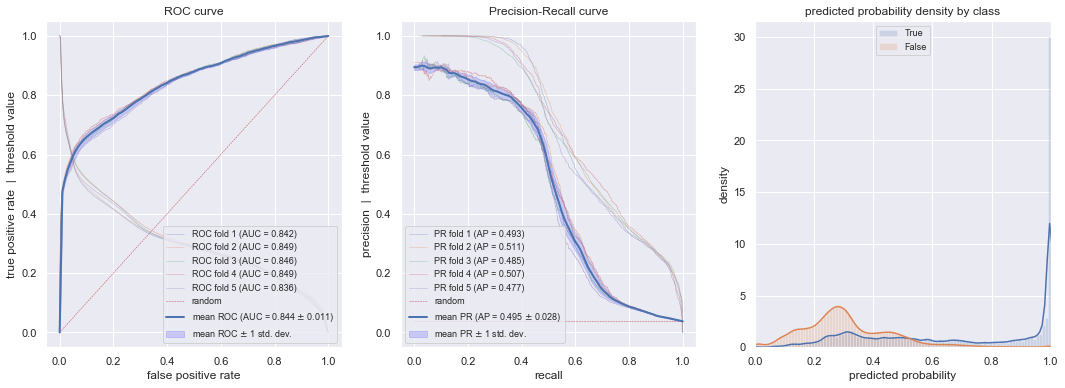

**sample 3**

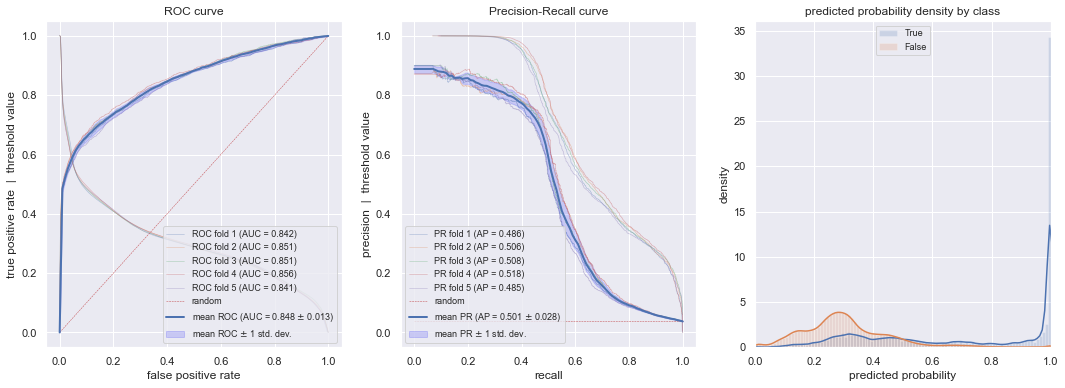

**sample 4**

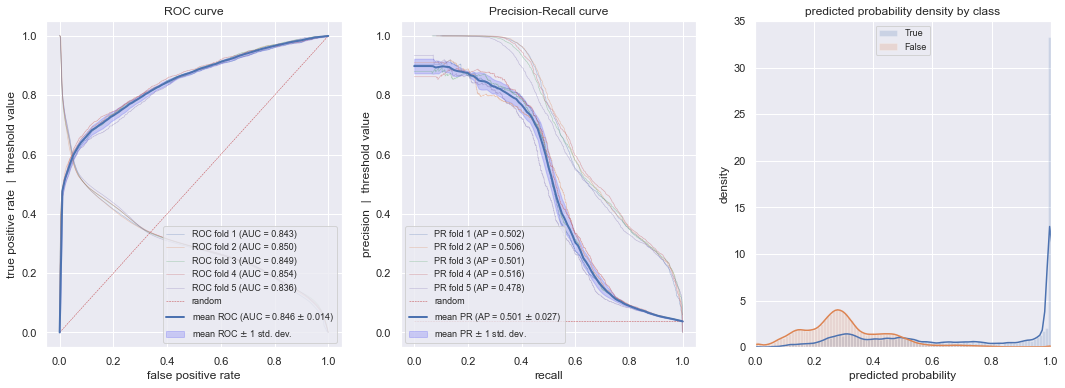

**sample 5**

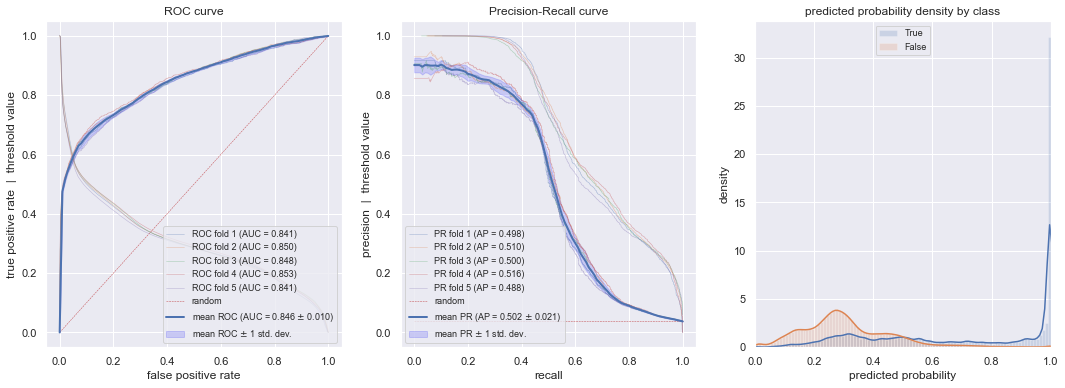

In [15]:
for i, metric in enumerate(metrics):
    print_md('**sample %d**' % (i + 1))
    plot_threshold_decision_metrics(metric, figsize=(18, 6))
    plt.show()

**sample 1**

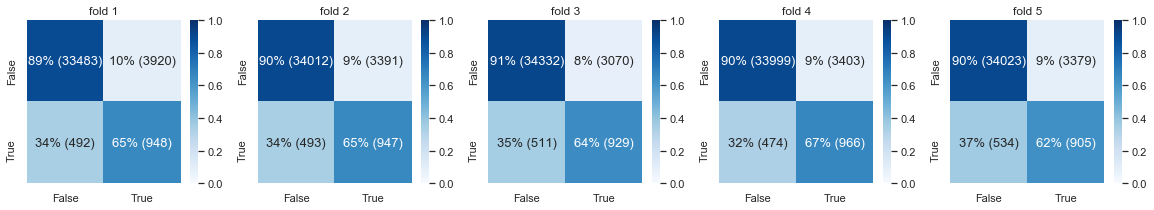

**sample 2**

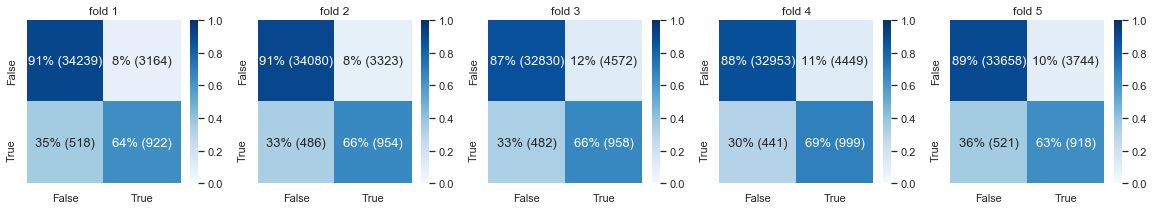

**sample 3**

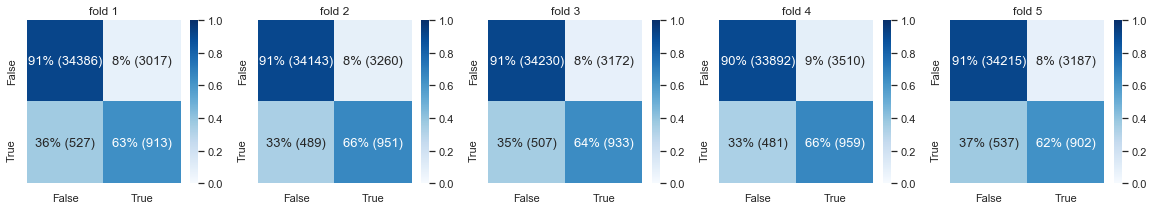

**sample 4**

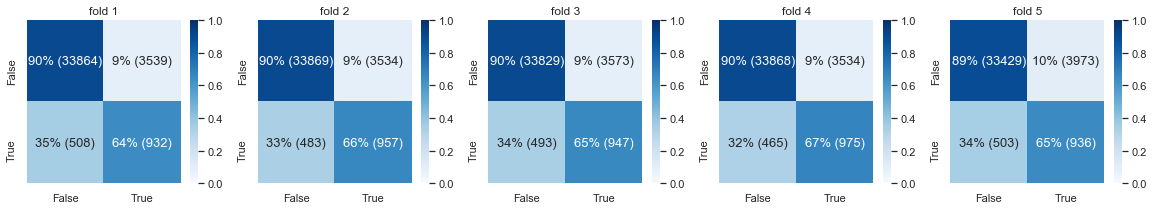

**sample 5**

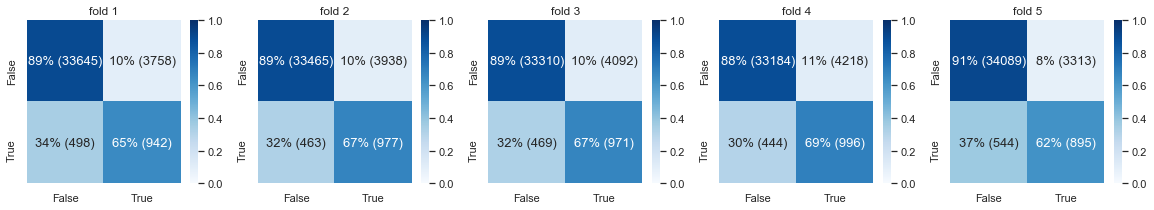

In [16]:
for i, metric in enumerate(metrics):
    print_md('**sample %d**' % (i + 1))
    plot_confusion_matrix(metric)
    plt.show()

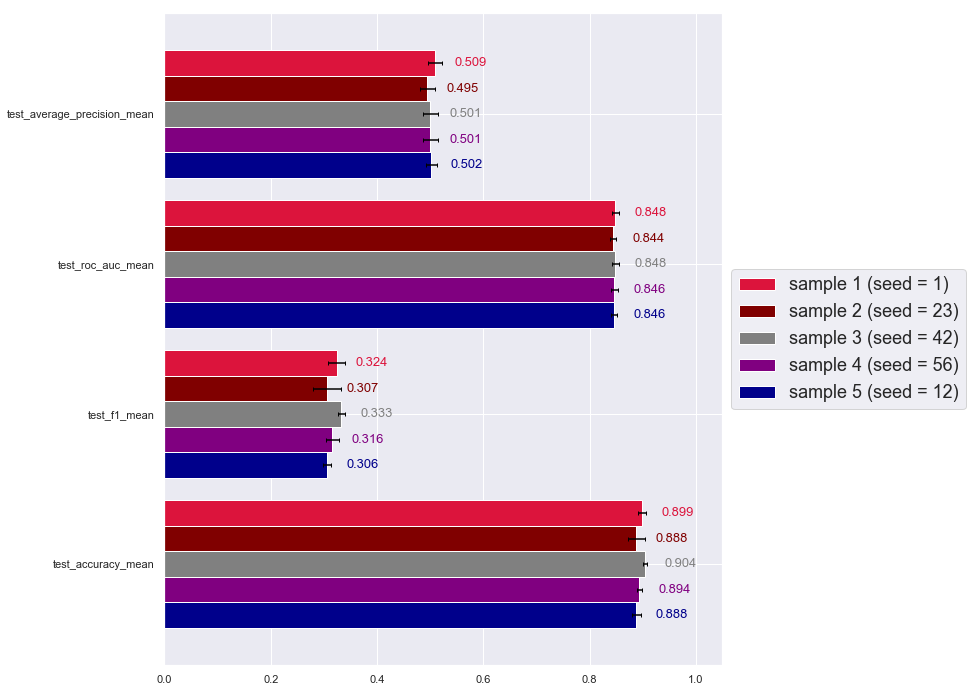

In [36]:
compare_models(summary)
#compare_models(summary, ['darkblue', 'indigo', 'purple', 'crimson', 'tomato', 'coral'], figsize=(10, 18))

## Random Forest

In [61]:
summary = pd.DataFrame(columns=['test_accuracy_mean', 'test_roc_auc_mean', 'test_f1_mean', 'test_average_precision_mean',
                                'test_accuracy_std' , 'test_roc_auc_std' , 'test_f1_std' , 'test_average_precision_std'])
summary.index.name = 'sampling_strategy'

In [23]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

metrics = []

for i, seed in enumerate([1, 23, 42, 56, 12]):
    print_md('**sample %d (seed = %s)**' % (i + 1, seed))
    
    model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=seed),
                          RandomForestClassifier(random_state=42, n_estimators=100, max_depth=30, criterion='entropy', n_jobs=5))
    
    metrics.append(run_model(model, X, y, cv_strategy, n_jobs=5))
    print_mean_metrics(metrics[-1])
    
    add_metrics_to_summary(summary, metrics[-1], 'sample %d (seed = %s)' % (i + 1, seed))

**sample 1 (seed = 1)**

Run model... done! (24.20s)
▴ Mean accuracy    : 0.882 ± 0.011
▴ Mean ROC AUC     : 0.893 ± 0.006
▴ Mean F1-score    : 0.320 ± 0.017
▴ Average precision: 0.568 ± 0.017


**sample 2 (seed = 23)**

Run model... done! (23.69s)
▴ Mean accuracy    : 0.885 ± 0.008
▴ Mean ROC AUC     : 0.894 ± 0.007
▴ Mean F1-score    : 0.326 ± 0.015
▴ Average precision: 0.572 ± 0.019


**sample 3 (seed = 42)**

Run model... done! (25.59s)
▴ Mean accuracy    : 0.884 ± 0.005
▴ Mean ROC AUC     : 0.893 ± 0.007
▴ Mean F1-score    : 0.324 ± 0.007
▴ Average precision: 0.571 ± 0.017


**sample 4 (seed = 56)**

Run model... done! (24.50s)
▴ Mean accuracy    : 0.883 ± 0.013
▴ Mean ROC AUC     : 0.892 ± 0.007
▴ Mean F1-score    : 0.323 ± 0.022
▴ Average precision: 0.573 ± 0.022


**sample 5 (seed = 12)**

Run model... done! (25.25s)
▴ Mean accuracy    : 0.883 ± 0.003
▴ Mean ROC AUC     : 0.893 ± 0.005
▴ Mean F1-score    : 0.321 ± 0.005
▴ Average precision: 0.569 ± 0.019


**sample 1**

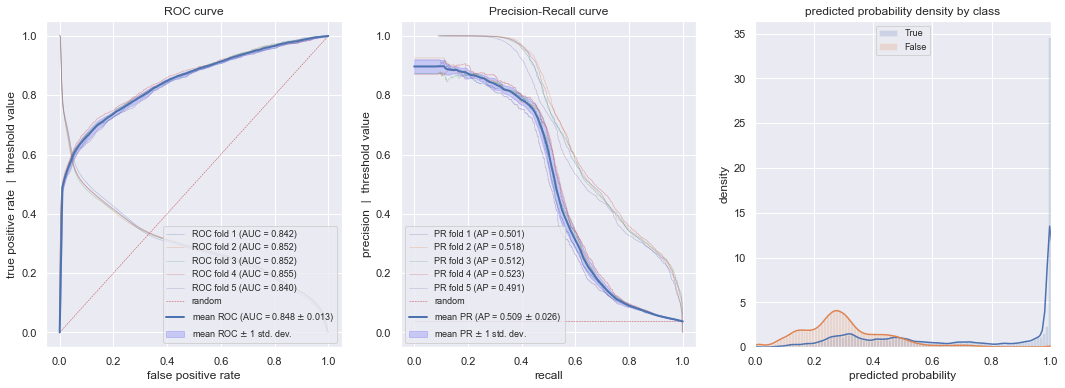

**sample 2**

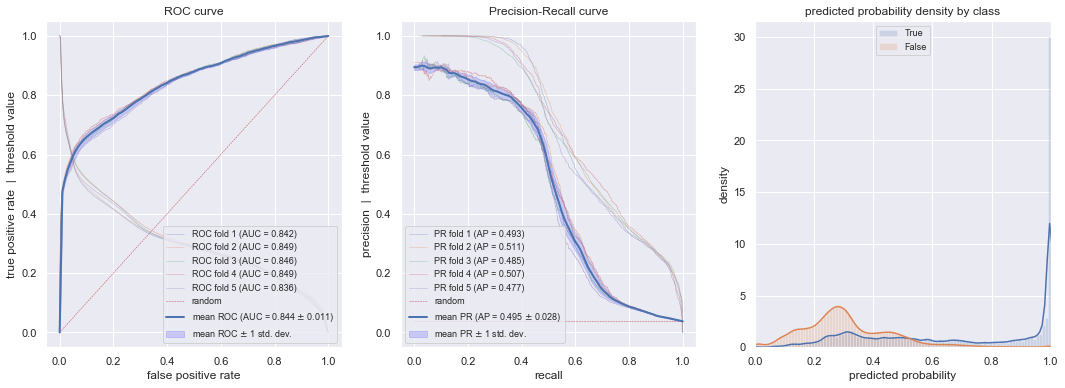

**sample 3**

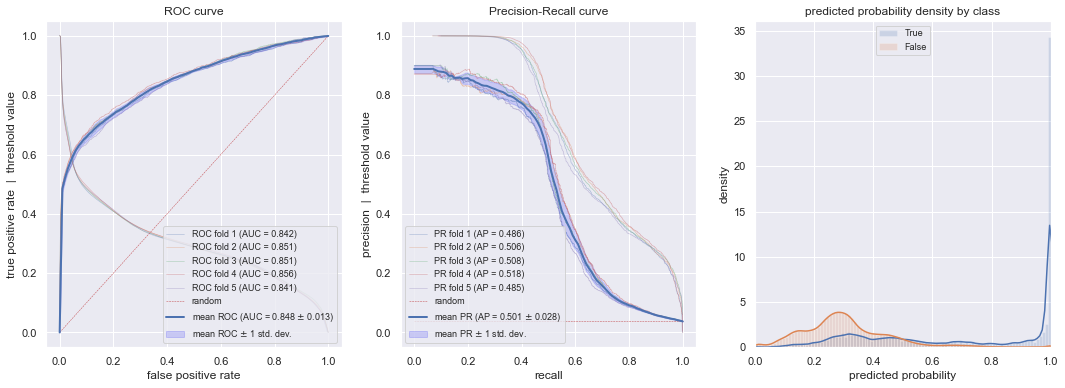

**sample 4**

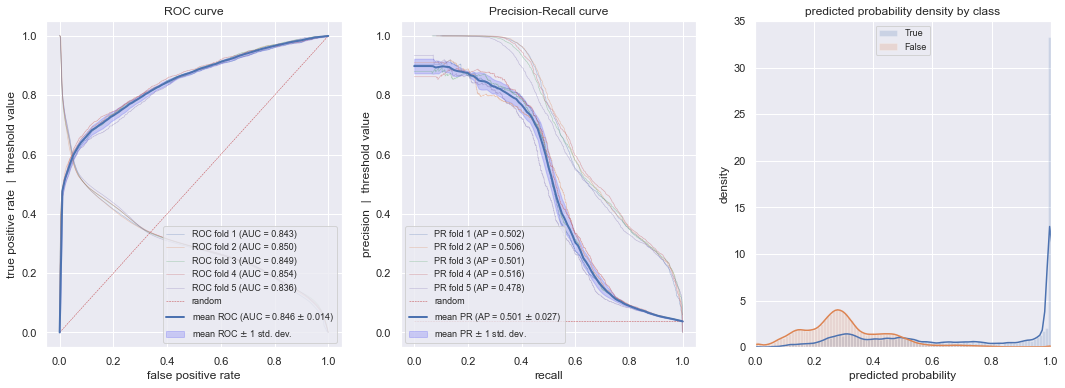

**sample 5**

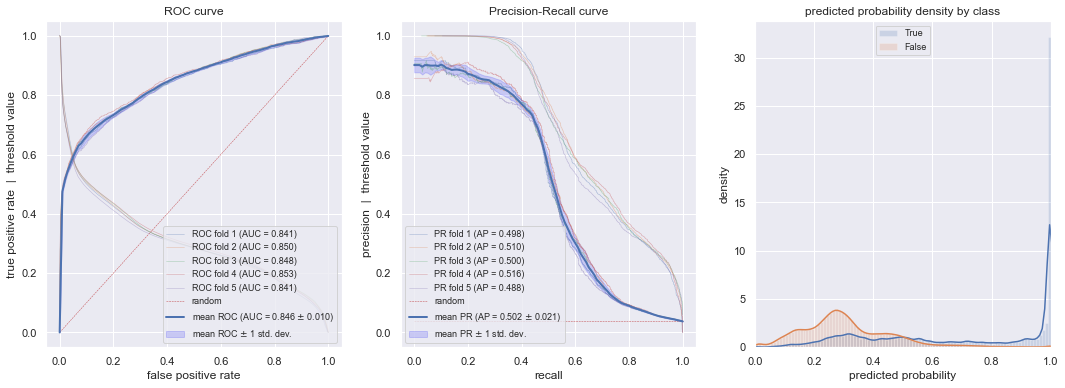

In [57]:
for i, metric in enumerate(metrics):
    print_md('**sample %d**' % (i + 1))
    plot_threshold_decision_metrics(metric, figsize=(18, 6))
    plt.show()

In [60]:
print(X.shape)
get_table(y)

(194211, 45)


count_  freq_
False  187012  96.3%
True     7199   3.7%

**sample 1**

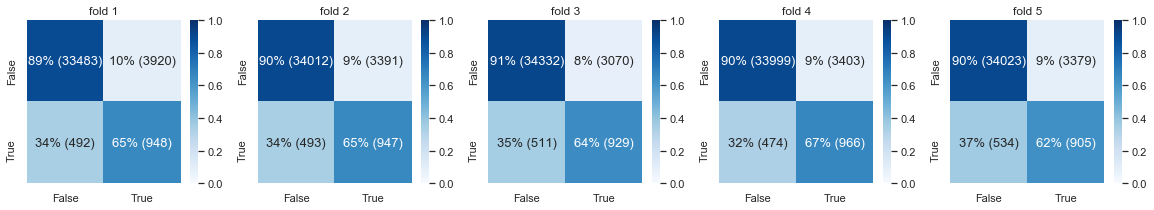

**sample 2**

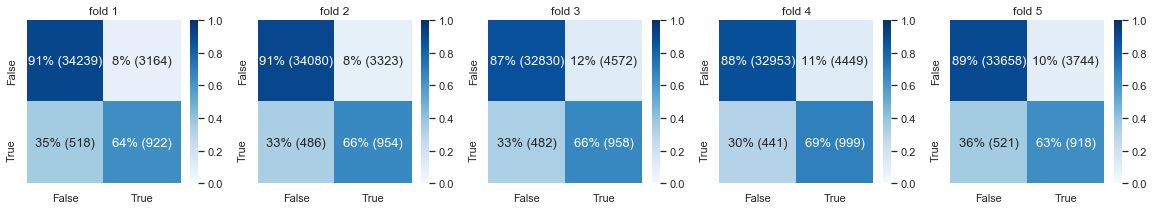

**sample 3**

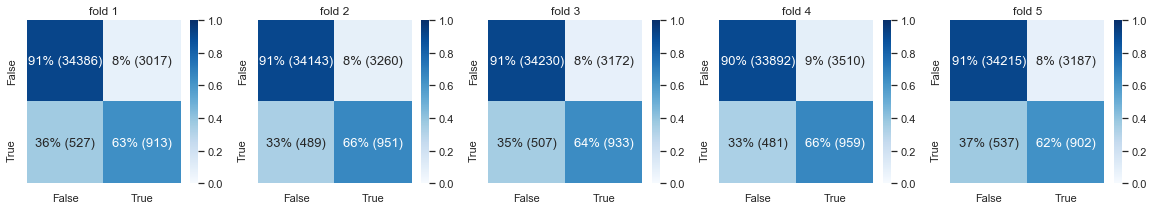

**sample 4**

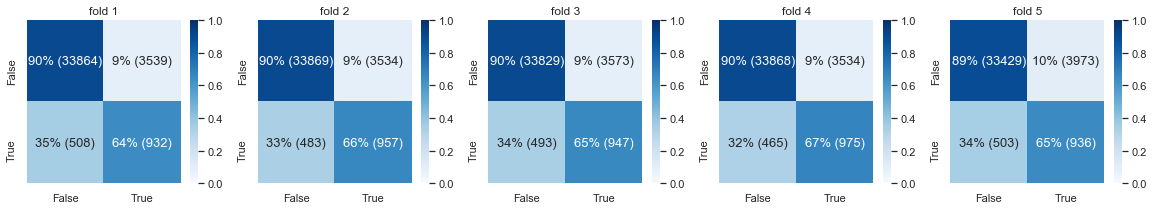

**sample 5**

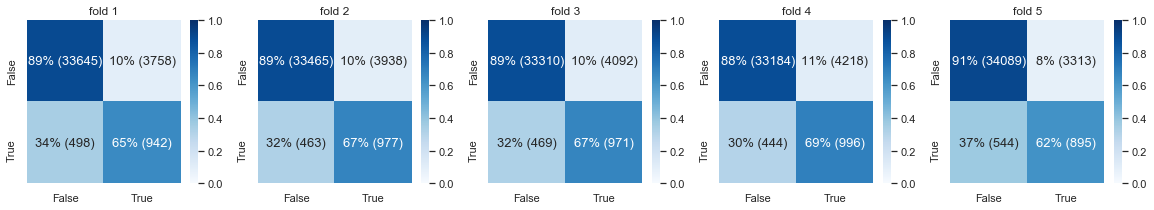

In [58]:
for i, metric in enumerate(metrics):
    print_md('**sample %d**' % (i + 1))
    plot_confusion_matrix(metric)
    plt.show()

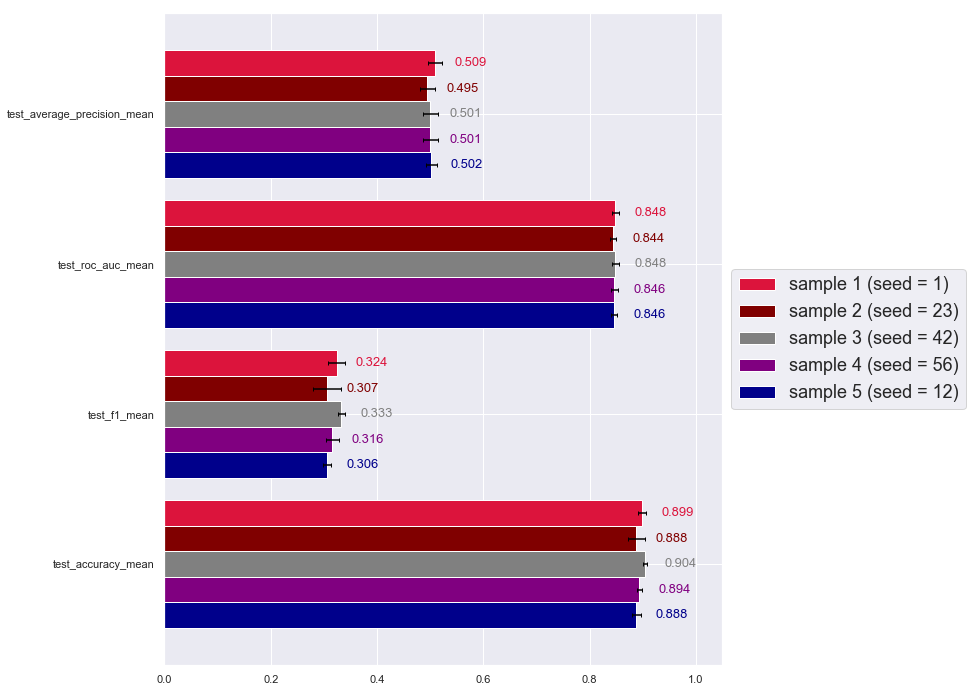

In [36]:
compare_models(summary)
#compare_models(summary, ['darkblue', 'indigo', 'purple', 'crimson', 'tomato', 'coral'], figsize=(10, 18))